# 高度なプロンプト：Chain of Thought and ReAct (Reasoning + Acting)

In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# I have released a Japanese translation of the original repository.
# Please find more information at:
#
#     https://github.com/narita-masaaki/langchain-palm-api-ja/tree/main

このノートブックは、**Chain of Thought and ReAct (Reasoning + Acting)に基づいています** [Applied-Ai-Engieering-examples](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples)GitHubリポジトリ。このリポジトリには、Google Cloud Applied AI Engineeringチームが開発したリファレンスガイド、青写真、コードサンプル、および実践的なラボが含まれています。

# パート0：はじめに

このノートブックのターゲットオーディエンスは、タスク、ワークフロー、プロセス、機能などを繰り返し実行するためのエンジニアリングプロンプトです。安定性とパフォーマンスは、1回限りのニーズを求めるよりも重要です。

このノートブックは、2つの強力なLLMプロンプト戦略をカバーしています。

React（およびそのバリアント）は、幻覚を最小限に抑えながらLLMの推論を改善するための現在の最先端のプロンプト技術です。

このノートブックの4つの部分は次のとおりです。

1. 思考のチェーンプロンプト：LLM出力を改善するために推論の言語説明を使用します。

1. アクション、検索、ツールの使用：LLMSが外部システムとどのように相互作用するか。

1. 反応（推論 +演技）プロンプト：外部システムの相互作用と考えられたチェーンプロンプトの書面による推論の説明を組み合わせます。

1. Langchain and React：Langchain React Agentを使用するときに何を期待するか。

このノートブックはColabでテストされました。

## このノートブックの使用方法

* 最初にパート0を実行します。
* パート1〜4それぞれパート0のコードに依存しますが、他の以前のパートのコードに依存しません。

## 前提条件

-  LLMS（大規模な言語モデル）の理解：
-  LLMとは何か、そしてそれらがどのように機能するか。
-LLMSは、次のトークンの繰り返し予測因子として。
-LLM予測は、トレーニングデータとの類似性を最大化します。
-  LLMプロンプトの経験：
- 言語モデルを「プロンプト」することの意味。[推奨リソース](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/introduction-plompt-design)。
-  [ゼロショット、ワンショット、少数のショット](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/introduction-plompt-design#include-xamplesの違い)プロンプト、およびパフォーマンスと堅牢性を最大化するために、少数のショットプロンプトが不可欠である理由を理解すること。
-Google Cloud Vertex LLMSに基本的な知識。[推奨リソース](https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/api-quickstart)
-  Langchainとは何か、それが解決することを目指している問題を知ってください。
-  [推奨リソース](https://python.langchain.com/docs/get_started/introduction)および[Tutorials](https://github.com/googlecloudplatform/generative-ai/tree/main/language/orchestration/langchain)。

## キー用語

一貫性のために、このノートブックは特定の方法で次の用語を使用します。

**プロンプト**：テンプレートに挿入される値に関係なく、コールのパフォーマンスと堅牢性を最大化する特定の手法を使用して作成されたテンプレートLLMコール。

**LLMコール**：LLMにテキストを送信します。

**LLM応答**：LLMによって予測されたテキスト、LLMコールを行うときにLLMから戻ってくるもの。

**チェーン/チェーン**コンテキストに応じて：
* 紹介されたチェーンのプロンプト、論理的に連続的な推論ステップ。
* LLMシステムでは、LLMへの連続呼び出し。各コールは前のコールの応答に依存します。

**exemplar**：1つまたは少数のプロンプトの「例」。
* 従来のMLの意味での「例」との混乱、つまり「データの一部」（「トレーニングの例」など）を避けるために使用されます。

## 参照

* 小島、タケシ、他「大規模な言語モデルはゼロショットの推論者です。」神経情報処理システムの進歩35（2022）：22199-22213。[link](https://arxiv.org/abs/2205.11916)（アクセス2023 09 22）
* Wang、Xuezhi、et al。「自己整合性は、言語モデルの一連の思考推論を改善します。」arxiv preprint arxiv：2203.11171（2022）。[link](https://arxiv.org/abs/2203.11171)（アクセス2023 09 03）。
*ウェイ、ジェイソン他「考えられたチェーンプロンプトは、大規模な言語モデルで推論を引き出します。」神経情報処理システムの進歩35（2022）：24824-24837。[link](https://arxiv.org/abs/2201.11903)（アクセス2023 09 03）。
* Yao、Shunyu、et al。「反応：言語モデルでの推論と行動の相乗効果。」Arxiv Preprint arxiv：2210.03629（2022）。[link](https://arxiv.org/abs/2210.03629)（アクセス2023 09 03）。

## セットアップ - このコードを最初に実行してください！

In [1]:
# Tested with these package versions.
# Note this notebook uses matplotlib.pyplot. This is in the default Colab
#   runtime, but you may need to install it in other notebook environments.

# 必要なライブラリをインストールします。
# - langchain: 大規模言語モデルを活用するためのフレームワーク (バージョン 0.0.316)
# - google-cloud-aiplatform: Google Cloud AI Platform の API を使用するためのライブラリ (バージョン 1.35.0)
# - prettyprinter: データ構造を見やすく出力するためのライブラリ (バージョン 0.18.0)
# - wikipedia: Wikipedia API を使用するためのライブラリ (バージョン 1.4.0)
# - numexpr: 数値式を高速に評価するためのライブラリ
!pip install --user langchain==0.0.316 google-cloud-aiplatform==1.35.0 prettyprinter==0.18.0 wikipedia==1.4.0 numexpr

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.4 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.0/405.0 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.2 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=3d0c9520cda4db45ffa016ebd20f60578aa52c9c1549b79cea46362f8abcd336
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-s

**さらに進む前にランタイムを再起動してください**

ランタイムが削除されていない限り（再起動しても）、この以前のセルを再実行する必要はありません。

ランタイムが再起動した場合、パート0の残りのセルを再実行します。

Colabを使用している場合は、次のセルでコードを実行します。[Vertex aiisifigine]を使用するには、Googleクラウド[プロジェクト](https://cloud.google.com/resource-manager/docs/creating-managing-projects#identifying_projects)にアクセスできるアカウントでポップアップをフォローし、認証します。llms](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview)。

Colab以外の場所でこのノートブックを実行している場合は、環境に適切なGoogleクラウドアクセスがあることを確認してください。それがあなたにとって新しい概念である場合は、[あなたのローカル環境のアプリケーションデフォルトの資格情報](https://cloud.google.com/docs/authentication/provide-credentials-adc#local-dev)を調べることを検討してください。より多くの認証オプションについて説明します[こちら](https://cloud.google.com/docs/authentication)。

Google Cloudをまったく初めて使用する場合は、[開始](https://cloud.google.com/docs/get-started)。

In [ ]:
# Colab authentication.
import sys

if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()
    print('Authenticated')

Google CloudプロジェクトIDを次のセルに設定します。

In [2]:
PROJECT_ID = "[your-project-id"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
# Code examples may misbehave if the model is changed.
MODEL_NAME = "text-bison@001"

In [3]:
# Vertex PaLM API を設定します。
# vertexai ライブラリをインポートします。
import vertexai
from vertexai.language_models import TextGenerationModel

# プロジェクト ID とロケーションを使用して vertexai を初期化します。
vertexai.init(project=PROJECT_ID,
              location=LOCATION)

# LLM のパラメータを設定します。
parameters = {
    "temperature": 0,  # 出力のランダム性を制御します (0 は最も確定的)
    "max_output_tokens": 1024,  # 生成される最大トークン数を設定します
    "top_p": 0.8,  # サンプリングに使用する確率の閾値を設定します
    "top_k": 40  # サンプリングに使用する上位 K 個のトークン数を設定します
}

# モデルを読み込みます。
model = TextGenerationModel.from_pretrained(MODEL_NAME)

I0000 00:00:1725966540.881507     356 config.cc:230] gRPC experiments enabled: call_status_override_on_cancellation, event_engine_dns, event_engine_listener, http2_stats_fix, monitoring_experiment, pick_first_new, trace_record_callops, work_serializer_clears_time_cache


この関数は、ノートブック全体で使用され、完全なLLMコールと応答を表示します。

In [4]:
# LLM を呼び出す関数を定義します。
def call_llm(model, parameters, llm_call, show_activity = True):
   # model.predict を使用して LLM を呼び出し、応答テキストを取得します。
  response = model.predict(llm_call, **parameters).text


  # show_activity が True の場合、呼び出しと応答を表示します。
  if show_activity:
    BOLD = "\033[1m"  # 太字にするためのエスケープシーケンス
    UNFORMAT = "\033[0m\x1B[0m"  # フォーマットをリセットするためのエスケープシーケンス
    print(f"{BOLD}The call to the LLM:{UNFORMAT}\n{llm_call}\n")  # 呼び出しを表示
    print(f"{BOLD}The response:{UNFORMAT}")  # 応答を表示
    print(response)  # 応答テキストを表示

  return response  # 応答テキストを返します

In [5]:
# Wrap code cell output to improve notebook readability.
# Source: https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results/61401455#61401455

# IPython.display から HTML と display をインポートします。
from IPython.display import HTML, display

# CSS を設定する関数を定義します。
def set_css(arg):
  # HTML を使用して CSS を定義し、display で表示します。
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

# セルの実行前に set_css 関数を呼び出すように登録します。
get_ipython().events.register('pre_run_cell', set_css)

# パート1：考え方のチェーンプロンプト

LLMSにとって、チェーンはファッショナブルなアクセサリー以上のものです。

<img src = "https://raw.githubusercontent.com/GoogleCloudPlatform/specialized-training-content/184be57c9ff4de18e20f3fdfbe1ef7fb35ce023f/courses/generative_ai/app_dev_llm/images/1-chains.png">

## 概要

考え方のプロンプトでは、目的の出力に到達するための推論ステップを示す1つまたは少数のショットの模範を提供します。これは、標準の1または少数のショットプロンプトとは異なり、模範が入力と正しい出力のみを示します。

思考の連鎖模範で提供する推論の内訳は、人が問題や仕事を通して考えている自然言語の内部モノローグに似ています。

「内部モノローグ」が奇妙な概念である場合、問題を解決したり、タスクを達成したりするために自分の考えを言語化する方法を考えてください。たとえば、あなたは夕食を作っています：

「OK OK私はセロリを切り刻みました。今、私は鶏肉を始める必要があります。オーブンはオンですか？オーブンの予熱を始めましょう。待って、どの温度？もう一度レシピをチェックする必要があります... `` `

この「内部モノローグ」または「内部スピーチ」は、タスクの次に何が起こるべきかを特定することにより、これまで見たことのない新しい問題に問題解決パターンを適用することを容易にします。

テキスト推論の「内部独白」を含む模範を使用してLLMを呼び出すことにより、LLMは同様のテキスト推論を含む応答を生成します。LLMに応答の一部として推論テキストが生成されると、応答が目的の出力で終了する可能性が高くなります。

応答の推論ステップ
また、LLMが最終出力にどのように到着したかの解釈可能性を提供します。

## 思考の基本の連鎖

数学の単語の問題は、数学的および論理的に単純なものであるが、推論の複数のステップが必要なため、良いチェーンのデモンストレーションです。

この例（思考の連鎖から[紙](https://arxiv.org/pdf/2201.11903.pdf)から）誤った答えに注意してください。

In [6]:
# LLM に対する質問を設定します。
question = """Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: The answer is 11.
Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:"""

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, question)

The call to the LLM:
Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: The answer is 11.
Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:

The response:
The answer is 19.


一連の思考を含めるために模範を書き直すことは、LLMに、質問を複数の単純な推論のステップに分解する方法を示しています。

モデル応答は、同様の思考の連鎖に従い、正解の可能性を高めます。

In [7]:
# LLM に対する質問を設定します。思考の連鎖の例を含めます。
question = """Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:"""

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, question)

The call to the LLM:
Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:

The response:
The cafeteria started with 23 apples. They used 20 apples to make lunch, so they have 23 - 20 = 3 apples left. They bought 6 more apples, so they now have 3 + 6 = 9 apples. The answer is 9.


思考の連鎖には、各推論ステップからのフォローするステップと中間出力/結論を説明するテキストの両方が含まれています。

以下のコードの「質問」変数を変更して、さまざまな質問を試してみてください。

In [8]:
# LLM に対する質問を設定します。
question = """Nomfundo writes legal briefs.
Each brief has 3 sections, each section takes 4 hours.
She wrote 3 briefs this week. How long did it take?"""

# 思考の連鎖を含む 1-shot の例題を設定します。
one_shot_exemplar = """Q: Roger has 5 tennis balls.
He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: """

# 1-shot の例題と質問を結合して、LLM への入力テキストを作成します。
llm_call = f"{one_shot_exemplar}{question}\nA:"

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Q: Roger has 5 tennis balls.
He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: Nomfundo writes legal briefs.
Each brief has 3 sections, each section takes 4 hours.
She wrote 3 briefs this week. How long did it take?
A:

The response:
Each brief has 3 sections, each section takes 4 hours, so 3 sections * 4 hours = 12 hours. She wrote 3 briefs this week, so 12 hours * 3 = 36 hours. The answer is 36.


LLM応答は通常、模範の推論スタイルを模倣します。これは、模範の推論のチェーンがタスクに適している場合、最高のパフォーマンスを得ることができます。

以下のセルを比較してください。

In [9]:
# LLM に対する質問を設定します。
question = """A high efficiency factory produces 100 units per day.
A medium efficiency factory produces 60 units per day.
A low efficiency factory produces 30 units per day.
Megacorp owns 5 factories. 3 are high efficiency, 2 are low efficiency.
Tomorrow they reconfigure a low efficiency factory up to medium efficiency.
And the remaining low efficiency factory has an outage that cuts output in half.
How many units can they produce today? How many tomorrow?"""

# 1-shot の例題を設定します (思考の連鎖は含まれません)。
one_shot_exemplar = """Q: Roger has 5 tennis balls.
He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: """

# 1-shot の例題と質問を結合して、LLM への入力テキストを作成します。
llm_call = f"{one_shot_exemplar}{question}\nA:" # 例題 + 質問 + 回答の開始

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Q: Roger has 5 tennis balls.
He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: A high efficiency factory produces 100 units per day.
A medium efficiency factory produces 60 units per day.
A low efficiency factory produces 30 units per day.
Megacorp owns 5 factories. 3 are high efficiency, 2 are low efficiency.
Tomorrow they reconfigure a low efficiency factory up to medium efficiency.
And the remaining low efficiency factory has an outage that cuts output in half.
How many units can they produce today? How many tomorrow?
A:

The response:
Today, the 3 high efficiency factories produce 3 * 100 = 300 units.
The 2 low efficiency factories produce 2 * 30 = 60 units.
So today, Megacorp produces 300 + 60 = 360 units.
Tomorrow, the reconfigured low efficiency factory produces 60 units.
The remaining low ef

出力の間違いに注意してください。LLM応答は、明日まだ実行されている3つの高効率工場を考慮していません。

このタスクでは、さまざまな測定単位（テニスボール缶対工場出力）への接続と、数日間の数の持ち運びを含む推論ステップを使用して、一連の思考を使用することをお勧めします。

In [10]:
# より適切な 1-shot の例題を設定します (思考の連鎖を含みます)。
better_one_shot_exemplar = """Q: A large tennis ball can has 5 balls.
A small tennis ball can has 3 balls.
Roger has 3 large cans and 2 small cans today.
Tomorrow he wins a bet and turns one small can into a large can.
How many balls does he have today? How many tomorrow?
A: 3 large cans is 3 * 5 = 15 tennis balls.
2 small cans is 2 * 3 = 6 tennis balls.
Today Roger has 15 + 6 = 21 tennis balls.
Tomorrow's trade means losing one small tennis ball can and gaining a large can.
Roger still has the cans he had yesterday.
2 small cans from yesterday - 1 = 1 small can
3 large cans from yesterday + 1 = 4 large cans
4 large cans is 4 * 5 = 20 tennis balls.
1 small can is 1 * 3 tennis balls.
Tomorrow Roger has 20 + 3 = 23 tennis balls.
Q: """

# より適切な 1-shot 例題と質問を結合して、LLM への入力テキストを作成します。
llm_call = f"{better_one_shot_exemplar}{question}\nA:"  # 例題 + 質問 + 回答の開始

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Q: A large tennis ball can has 5 balls.
A small tennis ball can has 3 balls.
Roger has 3 large cans and 2 small cans today.
Tomorrow he wins a bet and turns one small can into a large can.
How many balls does he have today? How many tomorrow?
A: 3 large cans is 3 * 5 = 15 tennis balls.
2 small cans is 2 * 3 = 6 tennis balls.
Today Roger has 15 + 6 = 21 tennis balls.
Tomorrow's trade means losing one small tennis ball can and gaining a large can.
Roger still has the cans he had yesterday.
2 small cans from yesterday - 1 = 1 small can
3 large cans from yesterday + 1 = 4 large cans
4 large cans is 4 * 5 = 20 tennis balls.
1 small can is 1 * 3 tennis balls.
Tomorrow Roger has 20 + 3 = 23 tennis balls.
Q: A high efficiency factory produces 100 units per day.
A medium efficiency factory produces 60 units per day.
A low efficiency factory produces 30 units per day.
Megacorp owns 5 factories. 3 are high efficiency, 2 are low efficiency.
Tomorrow they reconfigure a low effi

## 思考ユースケースの連鎖

数学の単語の問題はあまり役に立たないかもしれませんが、一連の思考は他のタイプの問題でうまく機能します。

思考の連鎖からのいくつかの例[紙](https://arxiv.org/pdf/2201.11903.pdf)は情報を操作し、妥当性を評価し、指示を与え、テキストを変更/理解し、状態を追跡しています。

<img src = "https://raw.githubusercontent.com/GoogleCloudPlatform/specialized-training-content/184be57c9ff4de18e20f3fdfbe1ef7fb35ce023f/courses/generative_ai/app_dev_llm/images/2-cot.png">

思考の連鎖によく反応する他のタイプのタスクは次のとおりです。
* データの変換と濃縮。
* データの解釈。
* コード生成。
* テキストの品質の評価（LLM応答の品質の評価を含む）。
* 合成データの作成。

一般的に、いくつかの簡単なステップを「話す」ことによって解決されるあらゆる種類の問題は、思考候補の良いチェーンです。

より複雑な思考の使用の使用のために、模範全体であなたの考え方の推論スタイルがより一貫しているほど、LLMはその応答において同じスタイルの推論に従う可能性が高くなります。これは次の2つの例に注意してください。

#### 例：テーブルの理解

In [11]:
# 正解は「戦後イギリス文学」です。
# LLM に対する質問（表形式のデータ）を設定します。
question = """
| Book Name | Edition | ISBN | Publisher | Aug 1 Amazon Avg New Price | Aug 1 Amazon Avg Used Price | Aug 1 Abebooks Avg New Price | Aug 1 Abebooks Avg Used Price | Sep 1 Amazon Avg New Price | Sep 1 Amazon Avg Used Price | Sep 1 Abebooks Avg New Price | Sep 1 Abebooks Avg Used Price |
|---|---|---|---|---|---|---|---|---|---|---|---|
| Physics for Computer Scientists | 10th | 978-1-118-56906-1 | Pearson Education | $149.99 | $79.99 | $142.94 | $66.94 | $129.99 | $59.99 | $139.94 | $56.94 |
| Fundamentals of Calculus | 8th | 978-0-470-45831-0 | John Wiley & Sons | $139.99 | $99.99 | $137.94 | $87.94 | $129.99 | $79.99 | $129.94 | $76.94 |
| Post-War British Literature | 2nd | 978-0-300-08897-2 | Oxford University Press | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| Modern Religions: An Overview | 3rd | 978-0-19-992545-3 | Oxford University Press | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |
| The Norton Introduction to Literature | 11th | 978-0-393-45078-1 | W. W. Norton & Company | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| The Norton Anthology of American Literature | 9th | 978-0-393-93750-8 | W. W. Norton & Company | $179.99 | $139.99 | $174.94 | $127.94 | $169.99 | $124.99 | $174.94 | $121.94 |
| The Norton Anthology of World Literature | 8th | 978-0-393-92855-6 | W. W. Norton & Company | $179.99 | $139.99 | $174.94 | $127.94 | $169.99 | $124.99 | $174.94 | $121.94 |
| The Elements of Style | 5th | 978-0-205-11265-3 | Longman | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |

What Oxford book dropped the most in used book price on Amazon between Aug and Sep?
"""

# LLM に対する指示を設定します。
context = """Answer questions about a table.
All questions must be supported by facts in the table.
All reasoning must be done step by step.
Explain the reasoning.
When looking at multiple rows, explain the reasoning for each row one by one.
"""

# 指示、質問、回答の開始を結合して、LLM への入力テキストを作成します。
llm_call = f"{context}\n{question}\nAnswer:"

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Answer questions about a table.
All questions must be supported by facts in the table.
All reasoning must be done step by step.
Explain the reasoning.
When looking at multiple rows, explain the reasoning for each row one by one.


| Book Name | Edition | ISBN | Publisher | Aug 1 Amazon Avg New Price | Aug 1 Amazon Avg Used Price | Aug 1 Abebooks Avg New Price | Aug 1 Abebooks Avg Used Price | Sep 1 Amazon Avg New Price | Sep 1 Amazon Avg Used Price | Sep 1 Abebooks Avg New Price | Sep 1 Abebooks Avg Used Price |
|---|---|---|---|---|---|---|---|---|---|---|---|
| Physics for Computer Scientists | 10th | 978-1-118-56906-1 | Pearson Education | $149.99 | $79.99 | $142.94 | $66.94 | $129.99 | $59.99 | $139.94 | $56.94 |
| Fundamentals of Calculus | 8th | 978-0-470-45831-0 | John Wiley & Sons | $139.99 | $99.99 | $137.94 | $87.94 | $129.99 | $79.99 | $129.94 | $76.94 |
| Post-War British Literature | 2nd | 978-0-300-08897-2 | Oxford University Press | $129.99 | $89.99 

次に、いくつかの模範を追加します。

模範は質問とは異なるソーステーブルを使用しているが、考え方のチェーンの推論はまだ機能していることに注意してください。

In [12]:
# few-shot の例題（表形式のデータと質問と回答）を設定します。
few_shot_exemplar = """
Table:
| Item Name | SKU | Vendor | Aug 1 Inventory | Sep 1 Inventory | Sale Count |
|---|---|---|---|---|---|
| iPhone 13 Pro Max | MGL83LL/A | Apple | 100 | 80 | 17 |
| iPhone 13 Pro | MLL03LL/A | Apple | 50 | 40 | 9 |
| iPhone 13 | MLKG3LL/A | Apple | 25 | 20 | 4 |
| Samsung Galaxy S22 Ultra | SM-S908U | Samsung | 100 | 80 | 19 |
| Samsung Galaxy S22 Plus | SM-S906U | Samsung | 50 | 40 | 10 |
| Samsung Galaxy S22 | SM-S901U | Samsung | 25 | 20 | 5 |
| Google Pixel 6 Pro | GA01314-US | Google | 100 | 80 | 20 |

Question:
What iPhone sold the most in August?
Answer: I need to look at each item one by one and determine if it is an iPhone.
Only iPhone items are considered.
The iPhone items are the iPhone 13 Pro Max, the iPhone 13 Pro, and the iPhone 13.
I need to look at how much each iPhone sold one by one, and then see which sold count is the highest.
iPhone 13 Pro Max sale count is 17.
iPhone 13 Pro sale count is 9.
iPhone 13 sale count is 4.
The biggest number of 17, 9, and 4 is 17.
The answer is iPhone 13 Pro Max.

Table:
| Item Name | SKU | Vendor | Aug 1 Inventory | Sep 1 Inventory | Sale Count |
|---|---|---|---|---|---|
| iPhone 13 Pro Max | MGL83LL/A | Apple | 100 | 80 | 17 |
| iPhone 13 Pro | MLL03LL/A | Apple | 50 | 40 | 9 |
| iPhone 13 | MLKG3LL/A | Apple | 25 | 20 | 4 |
| Samsung Galaxy S22 Ultra | SM-S908U | Samsung | 100 | 80 | 19 |
| Samsung Galaxy S22 Plus | SM-S906U | Samsung | 50 | 40 | 10 |
| Samsung Galaxy S22 | SM-S901U | Samsung | 25 | 20 | 5 |
| Google Pixel 6 Pro | GA01314-US | Google | 100 | 80 | 20 |

Question:
What Samsung phone has the most units unaccounted for on Sep 1?
Answer: I need to look at each item one by one and determine if it is a Samsung item.
I have to look at the Item Name for Samsung items.
Only Samsung items are considered.
The Samsung items are the S22 Ultra, the S22 Plus, and the S22.
One by one, I need to look at the Sep 1 and Aug 1 inventory difference for each Samsung item to see how many units should have been sold.
Then I need to compare that number to the actual sale count value for that item.
The phone with the biggest difference between the sale count field and the inventory differences is the most unaccounted for.
Samsung Galaxy S22 Ultra had 100 in stock Aug 1 and 80 in stock Sep 1. 100 minus 80 is 20 (100 - 80 = 20). Sale count is 19. 20 minus 19 is 1 (20 - 19 = 1). 1 unit is unaccounted for.
Samsung Galaxy S22 Plus had 50 in stock Aug 1 and 40 in stock Sep 1. 50 minus 40 is 10 (50 - 40 = 10). Sale count is 10. The sale count matches the inventory difference, no units are unaccounted for.
Samsung Galaxy S22 had 25 in stock Aug 1 and 20 in stock Sep 1. 25 minus 20 is 5 (25 - 20 = 5). Sale count is 5. 20 minus 19 is 1. The sale count matches the inventory difference, no units are unaccounted for.
Only the S22 Ultra had anything unaccounted for.
The answer is Samsung Galaxy S22 Ultra.

Table:
| Item Name | SKU | Vendor | Aug 1 Inventory | Sep 1 Inventory | Sale Count |
|---|---|---|---|---|---|
| iPhone 13 Pro Max | MGL83LL/A | Apple | 100 | 80 | 17 |
| iPhone 13 Pro | MLL03LL/A | Apple | 50 | 40 | 9 |
| iPhone 13 | MLKG3LL/A | Apple | 25 | 20 | 4 |
| Samsung Galaxy S22 Ultra | SM-S908U | Samsung | 100 | 80 | 19 |
| Samsung Galaxy S22 Plus | SM-S906U | Samsung | 50 | 40 | 10 |
| Samsung Galaxy S22 | SM-S901U | Samsung | 25 | 20 | 5 |
| Google Pixel 6 Pro | GA01314-US | Google | 100 | 80 | 20 |

Question:
What vendor had the most total sales?
Answer: I need to look at the vendors one by one.
I have to deduce the vendors from the Item Name field.
There are three unique vendors in the table: Apple, Samsung, and Google.
For each vendor, I need to find the sale count for each item one by one, then add up the sales counts.
The Apple items are the iPhone 13 Pro Max with 17 sales, the iPhone 13 Pro with 9 sales, and the iPhone 13 with 4 sales.
17 + 9 + 4 = 30. 30 Apple phones were sold.
The Samsung items are the Samsung Galaxy S22 Ultra with 19 sales, the Samsung Galaxy S22 Plus with 10 sales, and the Samsung Galaxy S22 with 5 sales.
19 + 10 + 5 = 34. 34 Samsung phones were sold.
The Google item is the Google Pixel 6 Pro with 20 sales. 20 Google phones were sold.
30 Apple, 34 Samsung, 20 Google. 34 is the biggest number, it is for Samsung sales.
The answer is Samsung.

Table:
| Item Name | SKU | Vendor | Aug 1 Inventory | Sep 1 Inventory | Sale Count |
|---|---|---|---|---|---|
| iPhone 13 Pro Max | MGL83LL/A | Apple | 100 | 80 | 17 |
| iPhone 13 Pro | MLL03LL/A | Apple | 50 | 40 | 9 |
| iPhone 13 | MLKG3LL/A | Apple | 25 | 20 | 4 |
| Samsung Galaxy S22 Ultra | SM-S908U | Samsung | 100 | 80 | 19 |
| Samsung Galaxy S22 Plus | SM-S906U | Samsung | 50 | 40 | 10 |
| Samsung Galaxy S22 | SM-S901U | Samsung | 25 | 20 | 5 |
| Google Pixel 6 Pro | GA01314-US | Google | 100 | 80 | 20 |

Question:
What item had the most sales?
Answer: I need to look at each item one by one.
The iPhone 13 Pro Max had 17 sales.
The iPhone 13 Pro had 9 sales.
The iPhone 13 had 4 sales.
The Samsung Galaxy S22 Ultra had 19 sales.
The Samsung Galaxy S22 Plus had 10 sales.
The Samsung Galaxy S22 had 5 sales.
The Google Pixel 6 Pro had 20 sales.
The sales numbers are 17, 9, 3, 19, 10, 5, and 20.
20 is the biggest sales number, that is for the Google Pixel 6 Pro.
The answer is the Google Pixel 6 Pro.

"""

# 指示、few-shot 例題、質問、回答の開始を結合して、LLM への入力テキストを作成します。
llm_call = f"{context}\n{few_shot_exemplar}{question}\nAnswer:"

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Answer questions about a table.
All questions must be supported by facts in the table.
All reasoning must be done step by step.
Explain the reasoning.
When looking at multiple rows, explain the reasoning for each row one by one.


Table:
| Item Name | SKU | Vendor | Aug 1 Inventory | Sep 1 Inventory | Sale Count |
|---|---|---|---|---|---|
| iPhone 13 Pro Max | MGL83LL/A | Apple | 100 | 80 | 17 |
| iPhone 13 Pro | MLL03LL/A | Apple | 50 | 40 | 9 |
| iPhone 13 | MLKG3LL/A | Apple | 25 | 20 | 4 |
| Samsung Galaxy S22 Ultra | SM-S908U | Samsung | 100 | 80 | 19 |
| Samsung Galaxy S22 Plus | SM-S906U | Samsung | 50 | 40 | 10 |
| Samsung Galaxy S22 | SM-S901U | Samsung | 25 | 20 | 5 |
| Google Pixel 6 Pro | GA01314-US | Google | 100 | 80 | 20 |

Question:
What iPhone sold the most in August?
Answer: I need to look at each item one by one and determine if it is an iPhone.
Only iPhone items are considered.
The iPhone items are the iPhone 13 Pro Max, the iPhone 13 Pro, and 

さらに2つの質問（読みやすさのモデルの呼び出しを抑制します）：

In [13]:
# 正解は $6.15 です。
# LLM に対する質問（表形式のデータ）を設定します。
question = """
Table:
| Book Name | Edition | ISBN | Publisher | Aug 1 Amazon Avg New Price | Aug 1 Amazon Avg Used Price | Aug 1 Abebooks Avg New Price | Aug 1 Abebooks Avg Used Price | Sep 1 Amazon Avg New Price | Sep 1 Amazon Avg Used Price | Sep 1 Abebooks Avg New Price | Sep 1 Abebooks Avg Used Price |
|---|---|---|---|---|---|---|---|---|---|---|---|
| Physics for Computer Scientists | 10th | 978-1-118-56906-1 | Pearson Education | $149.99 | $79.99 | $142.94 | $66.94 | $129.99 | $59.99 | $139.94 | $56.94 |
| Fundamentals of Calculus | 8th | 978-0-470-45831-0 | John Wiley & Sons | $139.99 | $99.99 | $137.94 | $87.94 | $129.99 | $79.99 | $129.94 | $76.94 |
| Post-War British Literature | 2nd | 978-0-300-08897-2 | Oxford University Press | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| Modern Religions: An Overview | 3rd | 978-0-19-992545-3 | Oxford University Press | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |
| The Norton Introduction to Literature | 11th | 978-0-393-45078-1 | W. W. Norton & Company | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| The Norton Anthology of World Literature | 8th | 978-0-393-92855-6 | W. W. Norton & Company | $179.99 | $139.99 | $174.94 | $127.94 | $169.99 | $124.99 | $174.94 | $121.94 |
| The Elements of Style | 5th | 978-0-205-11265-3 | Longman | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |

Question:
How much money would be saved if I purchased 3 new copies of the Elements of Style from Abe books instead of Amazon in August?
"""

# 指示、few-shot 例題、質問、回答の開始を結合して、LLM への入力テキストを作成します。
llm_call = f"{context}\n{few_shot_exemplar}{question}\nAnswer:"

# call_llm 関数を使用して LLM を呼び出し、結果を表示します (show_activity は False)。
print(call_llm(model, parameters, llm_call, show_activity=False))
print("\n\n") # 空白行を出力

# 正解は「Physics for Computer Scientists」です。
# LLM に対する質問（表形式のデータ）を設定します。
question = """
Table:
| Book Name | Edition | ISBN | Publisher | Aug 1 Amazon Avg New Price | Aug 1 Amazon Avg Used Price | Aug 1 Abebooks Avg New Price | Aug 1 Abebooks Avg Used Price | Sep 1 Amazon Avg New Price | Sep 1 Amazon Avg Used Price | Sep 1 Abebooks Avg New Price | Sep 1 Abebooks Avg Used Price |
|---|---|---|---|---|---|---|---|---|---|---|---|
| Physics for Computer Scientists | 10th | 978-1-118-56906-1 | Pearson Education | $149.99 | $79.99 | $142.94 | $66.94 | $129.99 | $59.99 | $139.94 | $56.94 |
| Fundamentals of Calculus | 8th | 978-0-470-45831-0 | John Wiley & Sons | $139.99 | $99.99 | $137.94 | $87.94 | $129.99 | $79.99 | $129.94 | $76.94 |
| Post-War British Literature | 2nd | 978-0-300-08897-2 | Oxford University Press | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| Modern Religions: An Overview | 3rd | 978-0-19-992545-3 | Oxford University Press | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |
| The Norton Introduction to Literature | 11th | 978-0-393-45078-1 | W. W. Norton & Company | $129.99 | $89.99 | $122.94 | $74.94 | $119.99 | $74.99 | $124.94 | $71.94 |
| The Norton Anthology of World Literature | 8th | 978-0-393-92855-6 | W. W. Norton & Company | $179.99 | $139.99 | $174.94 | $127.94 | $169.99 | $124.99 | $174.94 | $121.94 |
| The Elements of Style | 5th | 978-0-205-11265-3 | Longman | $119.99 | $79.99 | $117.94 | $72.94 | $114.99 | $69.99 | $114.94 | $66.94 |

Question: What book has the largest difference between new and used Aug Amazon prices?
"""

# 指示、few-shot 例題、質問、回答の開始を結合して、LLM への入力テキストを作成します。
llm_call = f"{context}\n{few_shot_exemplar}{question}\nAnswer:"

# call_llm 関数を使用して LLM を呼び出し
print(call_llm(model, parameters, llm_call, show_activity=False))

I need to find the price of 3 new copies of The Elements of Style from Amazon and Abebooks in August.
The price of 1 new copy of The Elements of Style from Amazon is $119.99.
The price of 3 new copies of The Elements of Style from Amazon is $119.99 * 3 = $359.97.
The price of 1 new copy of The Elements of Style from Abebooks is $117.94.
The price of 3 new copies of The Elements of Style from Abebooks is $117.94 * 3 = $353.82.
The difference in price is $359.97 - $353.82 = $6.15.
The answer is $6.15.



I need to look at the Aug 1 Amazon Avg New Price and the Aug 1 Amazon Avg Used Price for each book.
The difference between the new and used prices is the new price minus the used price.
The book with the largest difference is the one with the biggest difference between the new and used prices.
The book with the largest difference is Physics for Computer Scientists.
The new price is $149.99 and the used price is $79.99.
The difference is $149.99 - $79.99 = $70.00.
The answer is Physics fo

データ理解のユースケースの場合、データスキーマが事前にデータスキーマを知っている場合は、そのスキーマと一致する必要があります。

一般に、模範的なデータ構造がデータ構造の構造であるほど、LLMが正しく応答する可能性が高くなります。

#### 例：タグ付けデータと構造化されたデータ出力

LLMワークフローの2つの一般的なニーズは、説明からタグまたはカテゴリを生成し、構造化されたデータを出力することです。

この例は両方を行います。タグ付けのパフォーマンスは、特定のタグが最適な理由を通じて、チェーンオブテアの模範とともに改善されます（タグが選択された理由の解釈可能性を提供します）。

さらに、JSONのような一般的なデータ形式であっても、構造化されたデータ出力がどのように見えるかを示すと、パフォーマンスが向上します。

[データソース](https://data.amerigeoss.org/dataset/gsa-json-adc1d)。

In [14]:
# JSON データソースのエントリから、指定されたフィールドを含む JSON を出力する指示を設定します。
context = """Given a JSON entry of a data source, output a JSON with the following fields and explain the reasoning:
pii: True/False, the dataset contains Personally Identifiable Information.
age: How many years since the dataset was last modified.
keywords: New keywords to index this dataset under, beyond the current set of keywords.
The last text output should be the JSON.
"""

# LLM に対する質問（JSON データ）を設定します。
question = """
{
    "@type" : "dcat:Dataset",
    "description" : "<p>The MDS 3.0 Frequency Report summarizes information for active residents currently in nursing homes. The source of these counts is the residents MDS assessment record. The MDS assessment information for each active nursing home resident is consolidated to create a profile of the most recent standard information for the resident.</p>\n",
    "title" : "MDS 3.0 Frequency Report",
    "accessLevel" : "public",
    "identifier" : "465",
    "license" : "http://opendefinition.org/licenses/odc-odbl/",
    "modified" : "2016-04-05",
    "temporal" : "2012-01-01T00:00:00-05:00/2015-12-31T00:00:00-05:00",
    "contactPoint" : {
      "@type" : "vcard:Contact",
      "fn" : "Health Data Initiative",
      "hasEmail" : "mailto:HealthData@hhs.gov"
    },
    "bureauCode" : [ "009:38" ],
    "keyword" : [ "Activities of Daily Living (ADL)" ],
    "language" : [ "en" ],
    "programCode" : [ "009:000" ],
    "publisher" : {
      "@type" : "org:Organization",
      "name" : "Centers for Medicare & Medicaid Services",
      "subOrganizationOf" : {
        "@type" : "org:Organization",
        "name" : "Department of Health & Human Services"
      }
    }
  }


"""

# 指示、質問（JSONデータ）、回答の開始を結合して、LLMへの入力テキストを作成します。
llm_call = f"{context}\nJSON:{question}\nAnswer:"

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Given a JSON entry of a data source, output a JSON with the following fields and explain the reasoning:
pii: True/False, the dataset contains Personally Identifiable Information.
age: How many years since the dataset was last modified.
keywords: New keywords to index this dataset under, beyond the current set of keywords.
The last text output should be the JSON.

JSON:
{
    "@type" : "dcat:Dataset",
    "description" : "<p>The MDS 3.0 Frequency Report summarizes information for active residents currently in nursing homes. The source of these counts is the residents MDS assessment record. The MDS assessment information for each active nursing home resident is consolidated to create a profile of the most recent standard information for the resident.</p>
",
    "title" : "MDS 3.0 Frequency Report",
    "accessLevel" : "public",
    "identifier" : "465",
    "license" : "http://opendefinition.org/licenses/odc-odbl/",
    "modified" : "2016-04-05",
    "temporal" : "20

JSON形式は正しいですが、年齢は間違っており、キーワードは予測されていません。1つの模範を追加すると、正しい応答が得られます。

In [15]:
# one-shot の例題（JSON データと出力 JSON）を設定します。
one_shot_exemplar = """
JSON:
{

    "@type" : "dcat:Dataset",
    "description" : "The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries.",
    "title" : "Medicare Multi-Carrier Claims System",
    "accessLevel" : "restricted public",
    "dataQuality" : true,
    "identifier" : "b6ffafab-1cfd-42dd-b8cb-7a554efaefa7",
    "landingPage" : "http://www.cms.gov/Research-Statistics-Data-and-Systems/Computer-Data-and-Systems/Privacy/Systems-of-Records-Items/09-70-0501-MCS.html",
    "license" : "http://www.usa.gov/publicdomain/label/1.0/",
    "modified" : "2014-09-30",
    "rights" : "Contains personally identifiable information and is subject to the Privacy Act of 1974, as amended at 5 United States Code (U.S.C.) 552a.  Requests should be directed to the appropriate System Manager, identified in the System of Records notice.",
    "primaryITInvestmentUII" : "009-000004256, 009-000004254",
    "systemOfRecords" : "09-70-0501",

    "contactPoint" : {
      "@type" : "vcard:Contact",
      "fn" : "Health Data Initiative",
      "hasEmail" : "mailto:Healthdata@hhs.gov"
    },
    "bureauCode" : [ "009:38" ],
    "keyword" : [ "medicare", "part b", "claims" ],
    "programCode" : [ "009:078" ],
    "theme" : [ "Medicare" ],
    "publisher" : {
      "@type" : "org:Organization",
      "name" : "Centers for Medicare & Medicaid Services",
      "subOrganizationOf" : {
        "@type" : "org:Organization",
        "name" : "Department of Health & Human Services"
      }
    }
  }

Answer: The 'rights' tag says 'Contains personally identifiable information' so pii is True.
The 'modified' tag is '2014-09-30'. The current year is 2023, 2023 minus 2014 is 9, so the age is 9.
To determine keywords I will look at all the fields that describe the dataset.
Then I will take the most salient and distinctive aspects of the fields and make those keywords.
Looking at all the fields, the ones that describe the dataset are  "description" and "title".
The "title" field is "Medicare Multi-Carrier Claims System".
Good keywords from the "title" field are "medicare" and "claims".
The "description" field is ""The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries."
Good keywords from the "description" field are "medical insurance benefits".
Good proposed keywords from both fields are "medicare", "claims", and "medical insurance benefits".
Next inspect the "keyword" field to make sure the proposed keywords are not already included.
The "keyword" field contains the keywords "medicare", "part b", and "claims".
From our proposed keywords, "medicare" should not be output since it is already in the "keyword" field.
That leaves "claims" and "medical insurance benefits" as proposed keywords.

Output JSON:
{
  "pii" : true,
  "age" : 9,
  "keywords" : ["claims", "medical insurance benefits"]
}
"""

# 指示、one-shot 例題、質問（JSONデータ）、回答の開始を結合して、LLMへの入力テキストを作成します。
llm_call = f"{context}{one_shot_exemplar}\nJSON:{question}\nAnswer:"

# call_lm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Given a JSON entry of a data source, output a JSON with the following fields and explain the reasoning:
pii: True/False, the dataset contains Personally Identifiable Information.
age: How many years since the dataset was last modified.
keywords: New keywords to index this dataset under, beyond the current set of keywords.
The last text output should be the JSON.

JSON:
{

    "@type" : "dcat:Dataset",
    "description" : "The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries.",
    "title" : "Medicare Multi-Carrier Claims System",
    "accessLevel" : "restricted public",
    "dataQuality" : true,
    "identifier" : "b6ffafab-1cfd-42dd-b8cb-7a554efaefa7",
    "landingPage" : "http://www.cms.gov/Research-Statistics-Data-and-Systems/Computer-Data-and-Systems/Privacy/Systems-of-Records-Items/09-70-0501-MCS.html",
    "license" : "http://www.usa.gov/publicdomain/label/1.0/",
    "modified" :

出力は正しいですが、キーワードのオーバーラップの理由がより明確になる可能性があり、これにより、プロンプトがより堅牢になります。これを改善するために考えてから、1つのソリューションの次のセルをご覧ください。

In [16]:
# few-shot の例題（JSON データと出力 JSON）を設定します。
few_shot_exemplar = """
JSON:
{

    "@type" : "dcat:Dataset",
    "description" : "The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries.",
    "title" : "Medicare Multi-Carrier Claims System",
    "accessLevel" : "restricted public",
    "dataQuality" : true,
    "identifier" : "b6ffafab-1cfd-42dd-b8cb-7a554efaefa7",
    "landingPage" : "http://www.cms.gov/Research-Statistics-Data-and-Systems/Computer-Data-and-Systems/Privacy/Systems-of-Records-Items/09-70-0501-MCS.html",
    "license" : "http://www.usa.gov/publicdomain/label/1.0/",
    "modified" : "2014-09-30",
    "rights" : "Contains personally identifiable information and is subject to the Privacy Act of 1974, as amended at 5 United States Code (U.S.C.) 552a.  Requests should be directed to the appropriate System Manager, identified in the System of Records notice.",
    "primaryITInvestmentUII" : "009-000004256, 009-000004254",
    "systemOfRecords" : "09-70-0501",

    "contactPoint" : {
      "@type" : "vcard:Contact",
      "fn" : "Health Data Initiative",
      "hasEmail" : "mailto:Healthdata@hhs.gov"
    },
    "bureauCode" : [ "009:38" ],
    "keyword" : [ "medicare", "part b", "claims" ],
    "programCode" : [ "009:078" ],
    "theme" : [ "Medicare" ],
    "publisher" : {
      "@type" : "org:Organization",
      "name" : "Centers for Medicare & Medicaid Services",
      "subOrganizationOf" : {
        "@type" : "org:Organization",
        "name" : "Department of Health & Human Services"
      }
    }
  }

Answer: The "rights" field says 'Contains personally identifiable information' so pii is true.
The "modified" field is "2014-09-30". The current year is 2023, 2023 minus 2014 is 9, so the age is 9.
To determine keywords I will look at all the fields that describe the dataset.
Then I will take the most salient and distinctive aspects of the fields and make those keywords.
Looking at all the fields, the ones that describe the dataset are "description" and "title".
The "title" field is "Medicare Multi-Carrier Claims System".
Good keywords from the "title" field are "medicare" and "claims".
The "description" field is "The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries."
Good keywords from the "description" field are "medical insurance benefits".
Good proposed keywords from both fields are "medicare", "claims", and "medical insurance benefits".
Next inspect the "keyword" field to make sure the proposed keywords are not already included.
The "keyword" field contains the keywords "medicare", "part b", and "claims".
From our proposed keywords, "medicare" should not be output since it is already in the "keyword" field.
That leaves "claims" and "medical insurance benefits" as acceptable new keywords.

Output JSON:
{
  "pii" : true,
  "age" : 9,
  "keywords" : ["claims", "medical insurance benefits"]
}


JSON:
{
  "@type": "dcat:Dataset",
  "title": "Data.gov Top 10 Visiting Countries - Archival",
  "description": "This dataset provides top 10 visiting countries by month in Data.gov up to July 2013.",
  "modified": "2016-01-20",
  "accessLevel": "public",
  "identifier": "GSA-32491",
  "dataQuality": true,
  "describedBy": "http://www.data.gov/metric",
  "describedByType": "text/csv",
  "issued": "2013-05-13",
  "license": "https://creativecommons.org/publicdomain/zero/1.0/",
  "spatial": "United States",
  "publisher": {
      "@type": "org:Organization",
      "name": "General Services Administration"
  },
  "accrualPeriodicity": "R/P1M",
  "isPartOf": "GSA-2015-09-14-01",
  "contactPoint": {
      "@type": "vcard:Contact",
      "fn": "Hyon Joo Kim",
      "hasEmail": "mailto:hyon.kim@gsa.gov"
  },
  "distribution": [{
          "@type": "dcat:Distribution",
          "mediaType": "text/csv",
          "format": "text/csv",
          "title": "Data.gov_Top_10_Visiting_Countries.csv",
          "downloadURL": "https://inventory.data.gov/dataset/b0d40da1-a505-476a-a49b-cfc50ea6d9da/resource/0a1a3fb8-a813-4470-b50c-51b7856203be/download/userssharedsdfdata.govtop10visitingcountries.csv"
      }
  ],
  "keyword": ["Countries", "Interactive"],
  "bureauCode": ["023:00"],
  "programCode": ["023:019"],
  "language": ["us-EN"],
  "theme": ["Countries", "Top 10"]
  }

Answer: The "accessLevel" field says "public" so pii is False.
The "modified" field is "2016-01-20". The current year is 2023, 2023 minus 16 is 7, so the age is 8.
To determine keywords I will look at all the fields that describe the dataset.
Then I will take the most salient and distinctive aspects of the fields and make those keywords.
Looking at all the fields, the ones that describe the dataset are  "description" and "title".
The "title" field is "Data.gov Top 10 Visiting Countries - Archival".
Good keywords from the "title" field are "data.gov", "top 10".
The "description" field is "This dataset provides top 10 visiting countries by month in Data.gov up to July 2013."
Good keywords from the "description" field are "top 10" and "visiting countries".
Good proposed keywords from both fields are "data.gov", "top 10", and "visiting countries".
Next inspect the "keyword" field to make sure the proposed keywords are not already included.
The "keyword" field contains the keywords "Countries" and "Interactive"
None of the proposed keywords are in the "keyword" field.
"data.gov", "top 10", and "visiting countries" are all acceptable new keywords.

Output JSON:
{
  "pii" : false,
  "age" : 9,
  "keywords" : ["data.gov", "top 10", "visiting countries"]
}
"""

# 指示、few-shot 例題、質問（JSONデータ）、回答の開始を結合して、LLMへの入力テキストを作成します。
llm_call = f"{context}{few_shot_exemplar}\nJSON:{question}\nAnswer:"

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Given a JSON entry of a data source, output a JSON with the following fields and explain the reasoning:
pii: True/False, the dataset contains Personally Identifiable Information.
age: How many years since the dataset was last modified.
keywords: New keywords to index this dataset under, beyond the current set of keywords.
The last text output should be the JSON.

JSON:
{

    "@type" : "dcat:Dataset",
    "description" : "The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries.",
    "title" : "Medicare Multi-Carrier Claims System",
    "accessLevel" : "restricted public",
    "dataQuality" : true,
    "identifier" : "b6ffafab-1cfd-42dd-b8cb-7a554efaefa7",
    "landingPage" : "http://www.cms.gov/Research-Statistics-Data-and-Systems/Computer-Data-and-Systems/Privacy/Systems-of-Records-Items/09-70-0501-MCS.html",
    "license" : "http://www.usa.gov/publicdomain/label/1.0/",
    "modified" :

## zero-shotの思考チェーン（「段階的に考えましょう」）

ゼロショットチェーンの考え方は、LLMコールの最後に「トリガー文」を追加するときです。たとえば、「段階的に考えましょう」、「深呼吸をすることから始めます」、または「解決策：」。これは、迅速かつ簡単なパフォーマンスを向上させる方法であり、さまざまなタスクに柔軟に対応できます（一方、少数の思考の連鎖には、質問に似ている必要があります）。

ただし、ゼロショットの思考チェーンは、ほぼすべての状況で数ショットのパフォーマンスを低下させます。さらに、ゼロショットの思考チェーンでは、LLMを2回呼び出す必要があります - 応答を生成するために、そして再び応答から答えを抽出する必要があります（応答構造を示す模範がないため）。最後に、ゼロショットのチェーンオブテアは、質問に答えるのではなく、質問を再定義する傾向があります。

一般的に、少数のショットチェーンの模範を書くときのインスピレーションを除いて、堅牢なプロンプトをエンジニアリングする場合は、ゼロショットチェーンの考え方は推奨されません。

## 思考の連鎖の利点

1. 最小限の努力のための簡単なLLM品質の向上。
1. 問題を解決するための手順を口頭で「話す」ことによって解決できるタスクに適用できます。
1. 解釈可能性。これにより、デバッグが支援され、エンドユーザーの解釈が必要なユースケースが可能になります。
1. 既製のLLMSで動作し、追加のLLMトレーニングやチューニングは必要ありません。
1. 異なるLLM間の堅牢性。考えられたチェーンプロンプトからの最終的な出力は、ドリフトを減らします。

##思考の短所

1. 長いLLMコールと応答によるコストの増加。
1. 推論時間が遅い。
1. 幻覚はまだ可能です。

## 思考のチェーンベストプラクティス

これらの推奨事項は、現在の理解を反映しており、LLMはすべて急速に変化しています。これのいくつかは、特定のコーナーケースとLLMアーキテクチャでは間違っている可能性があります。

これらのベストプラクティスの例外を見つけた場合は、GitHubの問題を提出することを検討してください。

### 重要なベストプラクティス

思考の連鎖から良いパフォーマンスを得るには、これらのベストプラクティスに従う必要があります。

1. 小さなLLMを**使用しない**でください。
  * 理想的には、少なくとも15BパラメーターのLLMを使用します。
  * 蒸留や改良されたLLMアーキテクチャのような技術が、最終的にこのアドバイスを変えることを期待したい。
1. 思考の連鎖の前に答えを書くのではなく、思考の連鎖の後に答えを書く。
1. [温度](https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/api-quickstart#try_text_text_prompts)を0に設定する。
1. ワンショットやゼロショットだけでなく、数ショットの思考連鎖を使うこと。
1. ステップ・バイ・ステップで推論を話すときに言うことをすべて盛り込んだ模範解答を書くこと。
  * 思考の連鎖には自然言語による推論が必要だ。
  * 自然言語による推論の代わりに数式を使わない。自然言語を補足するために方程式を加えるのは構わない。
1. 思考の連鎖が幻覚を止めると決めつけてはいけない。
  * 思考の連鎖はLLMの推論能力を向上させるが、LLMが事実をでっち上げることを止めるわけではない。

### 追加のベストプラクティス

思考の連鎖から最大限に活用するためのより多くのヒント。

1. Few-Shotプロンプト作成のDo's and Don'ts
Don't 過度にFew-Shot事例の順序にこだわる必要はありません。パフォーマンスに変化はないでしょう。

  * 分類タスクは例外です。同じクラスの事例を連続して複数提示しないようにしましょう。

1. Do Chain-of-Thoughtプロンプトが失敗する箇所を分析し、よくある失敗に対処するためのFew-Shot事例を作成しましょう。

1. Don't 最初から6つ以上のFew-Shot事例を作成する必要はありません。タスクによっては、それ以上の事例が役立つ場合もありますが、多くの場合は不要です。

1. Do 複数のプロンプトエンジニアにそれぞれ最適なプロンプトを作成してもらいましょう。

  * 例えば、3つのタスクがあり、3人のプロンプトエンジニアがいる場合、各エンジニアが1つのタスクに集中するよりも、全員が3つのタスクのプロンプトを作成する方が良い結果が得られるでしょう。

1. Don't タスクに必要な推論ステップが1つか2つの場合、Chain-of-Thoughtで結果が改善するとは期待しないでください。

1. Don't 事例とタスクの推論ステップ数を厳密に一致させることに気を使いすぎる必要はありません。

  * 推論のスタイルや構造を一致させる方が重要です。
  * ステップ数を一致させることができればパフォーマンス上の利点がありますが、できなくてもChain-of-Thoughtは依然としてパフォーマンス向上に貢献します。

1. Do LLMをチューニングする際にChain-of-Thoughtを追加しましょう。

  * LLMに質問と回答からChain-of-Thoughtによる推論を生成させ、その推論をチューニングデータの回答に追加することができます。
  * プロンプトとチューニングは二者択一ではありません。チューニングデータの入力が適切に設計されたプロンプトを含む場合、最適なチューニングモデルパフォーマンスが得られます。

1. Do データ分布に一致する事例を含めましょう。

  * 例えば、データがクラスA 80%、クラスB 20%で、5つのFew-Shot事例を作成する場合、4つの事例はクラスA、1つの事例はクラスBにするべきです。
  * 分類タスクでは事例の順序が重要になることもありますが、クラス分布を一致させることで順序に対する頑健性が高まります。
  * 連続して同じクラスの事例を複数提示しないように注意しましょう。

## 自己整合性

自己整合性は、一連の思考プロンプトのパフォーマンスを改善するための手法です。同じLLMコールを複数回呼び出して、最も一般的な答えを出します。

これは、温度= 0で思考の連鎖を使用するためのルールを「破る」ことを意味します。

自己整合性の背後にある直観は次のとおりです。
1.同一のLLM呼び出しに対する複数の応答は、応答のさまざまな推論パスを意味します。
1.誤った推論パスは、異なる誤った回答につながります。
1.正しい推論パスは同じ正解につながります。
1.いくつかの正解と多くの誤った答えしか得られないかもしれませんが、正解は一意の誤った答えよりも一般的です。

自己整合性を試してみましょう。まず、温度0でこの次のLLM呼び出しを実行して、誤った応答を生成します。

In [17]:
# 正解は 1300 + 100 (maintenance) + 75 (upgrade) = 1475 です。
# LLM に対する質問を設定します。
question = """Factories have a baseline productivity of 100 units per day.
Not all factories have the baseline productivity.
When a factory is being upgraded, it has 25% of the baseline productivity.
When a factory is undergoing maintenance, it has 50% of the baseline.
When a factory is under labor action, it produces nothing.
Megacorp has 19 factories in total.
3 factories are being upgraded.
2 factories are under maintenance.
1 is under labor action.
How many units does megacorp produce in a day?"""

# LLM に対する指示を設定します。
context = """Answer questions showing the full math and reasoning.
Follow the pattern in the example.
"""

# one-shot の例題（質問と回答）を設定します。
one_shot_exemplar = """Q: A regular tennis ball can holds 5 balls.
A large tennis ball can holds 200% of a regular tennis ball can.
A small tennis ball can holds 40% of a regular tennis ball can.
A collectable tennis ball can holds no tennis balls.
Roger has 10 tennis ball cans.
3 cans are large cans.
4 cans are small cans.
1 can is collectable.
How many tennis balls does Roger have?
A: We need to find the number of regular tennis ball cans.
Roger has 10 (total) - 3 (large) - 4 (small) - 1 (collectable) = 2 regular cans.
A large tennis ball can holds 200% of 5 = 10 tennis balls.
A small tennis ball can holds 40% of 5 = 2 tennis balls.
Next count how many balls come from each can type.
3 large cans is 3 * 10 = 30 tennis balls.
4 small cans is 2 * 4 = 8 tennis balls.
2 regular cans is 2 * 5 = 10 tennis balls
1 collectable can is 0 tennis balls.
To get the answer, add the number of balls from each can type.
Roger has 30 (large) + 8 (small) + 10 (regular) + 0 (collectable) = 48 balls.
The answer is 48.

Q: """

# 指示、one-shot 例題、質問、回答の開始を結合して、LLM への入力テキストを作成します。
llm_call = f"{context}\n{one_shot_exemplar}{question}\nA:"

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, llm_call)

The call to the LLM:
Answer questions showing the full math and reasoning.
Follow the pattern in the example.

Q: A regular tennis ball can holds 5 balls.
A large tennis ball can holds 200% of a regular tennis ball can.
A small tennis ball can holds 40% of a regular tennis ball can.
A collectable tennis ball can holds no tennis balls.
Roger has 10 tennis ball cans.
3 cans are large cans.
4 cans are small cans.
1 can is collectable.
How many tennis balls does Roger have?
A: We need to find the number of regular tennis ball cans.
Roger has 10 (total) - 3 (large) - 4 (small) - 1 (collectable) = 2 regular cans.
A large tennis ball can holds 200% of 5 = 10 tennis balls.
A small tennis ball can holds 40% of 5 = 2 tennis balls.
Next count how many balls come from each can type.
3 large cans is 3 * 10 = 30 tennis balls.
4 small cans is 2 * 4 = 8 tennis balls.
2 regular cans is 2 * 5 = 10 tennis balls
1 collectable can is 0 tennis balls.
To get the answer, add the number of balls from each can 

次に、「温度」を.7に上げ、高い「TOP_P」と「TOP_K」値を使用して異なる応答を生成します。

次のセルを数回実行し、答えがどのように変化するかに注意してください。

In [18]:
# LLM のパラメータを self-consistency 用に調整
sc_parameters = {
    "temperature": 0.7,  # 出力のランダム性を高めます (0.7)
    "max_output_tokens": 512,  # 生成される最大トークン数を設定します (512)
    "top_p": 1,  # サンプリングに使用する確率の閾値を設定します (1)
    "top_k": 40  # サンプリングに使用する上位 K 個のトークン数を設定します (40)
}

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, sc_parameters, llm_call)

The call to the LLM:
Answer questions showing the full math and reasoning.
Follow the pattern in the example.

Q: A regular tennis ball can holds 5 balls.
A large tennis ball can holds 200% of a regular tennis ball can.
A small tennis ball can holds 40% of a regular tennis ball can.
A collectable tennis ball can holds no tennis balls.
Roger has 10 tennis ball cans.
3 cans are large cans.
4 cans are small cans.
1 can is collectable.
How many tennis balls does Roger have?
A: We need to find the number of regular tennis ball cans.
Roger has 10 (total) - 3 (large) - 4 (small) - 1 (collectable) = 2 regular cans.
A large tennis ball can holds 200% of 5 = 10 tennis balls.
A small tennis ball can holds 40% of 5 = 2 tennis balls.
Next count how many balls come from each can type.
3 large cans is 3 * 10 = 30 tennis balls.
4 small cans is 2 * 4 = 8 tennis balls.
2 regular cans is 2 * 5 = 10 tennis balls
1 collectable can is 0 tennis balls.
To get the answer, add the number of balls from each can 

上記のコードを再実行すると、さまざまな推論と回答が表示されます。

次に、多くの応答をループして生成し、回答を抽出し、回答を最も一般的で最も一般的ではないように出力します。

これには数分かかります。実行中は、さまざまな推論と回答に注意してください。

In [19]:
# self-consistency を使用するための準備を行います。
# collections モジュールから Counter をインポートします。
from collections import Counter  # 最頻値の回答を簡単にカウントするために使用します。

# self-consistency の実行回数を設定します。
sc_runs = 40

# 応答と回答を格納するためのリストを作成します。
responses = [None] * sc_runs  # LLM からの応答を格納するリスト (sc_runs 個の要素)
answers = [None] * sc_runs  # 回答 (数値) を格納するリスト (sc_runs 個の要素)

# self-consistency を実行し、結果を分析します。
# sc_runs 回数分、LLM を呼び出して回答を取得します。
for i in range(0, sc_runs):
  print(f"Response {i}...") # 処理中の応答番号を表示
  responses[i] = call_llm(model,
                          sc_parameters,
                          llm_call,
                          show_activity=False) # LLM を呼び出し、show_activity は False

  # 応答に'The answer is'が含まれていない場合、分割は失敗する。
  # 答えに小数やカンマが含まれている場合も # 分割は失敗します.
  # 回答からテキストを抽出します。
  try:
    # "The answer is" で分割し、最初の文を取得
    answers[i] = responses[i].split("The answer is")[1].split(".")[0].strip()
  except Exception as e:
    answers[i] = "NA"  # 抽出に失敗した場合は "NA" を設定
  print(responses[i]) # LLM からの応答を表示

# 回答の出現頻度をカウントし、表示します。
print("Answers and counts from most common to least common:")
print(Counter(answers).most_common())

Response 0...
The upgraded factories have a productivity of 100 * .25 = 25 units per day.
The factories undergoing maintenance have a productivity of 100 * .5 = 50 units per day.
The factory under labor action is not productive.
We can calculate the total productive capacity of the factories as 19 * 100 = 1900 units per day.
The factories being upgraded, under maintenance, or under labor action will not be able to produce their full capacity.
The upgraded factories will produce 3 * 25 = 75 units per day.
The factories under maintenance will produce 2 * 50 = 100 units per day.
The factory under labor action will produce 0 units per day.
The total productivity of the factories that are not under labor action is 1900 - 75 - 100 = 1725 units per day.
The final answer: 1725.
Response 1...
1 factory produces 100 * .25 = 25 units per day when it is being upgraded.
1 factory produces 100 * .50 = 50 units per day when it is under maintenance.
1 factory produces 0 units per day when it is under 

上記のセルからの最後の出力は、異なる回答のカウントです。正解（1475）は、最も一般的な答えとして戻ってくるはずです。

LLMの呼び出しが多いほど、最も一般的な答えは正しい答えです。

また、結果をプロットして、回答の分布を視覚化することもできます。

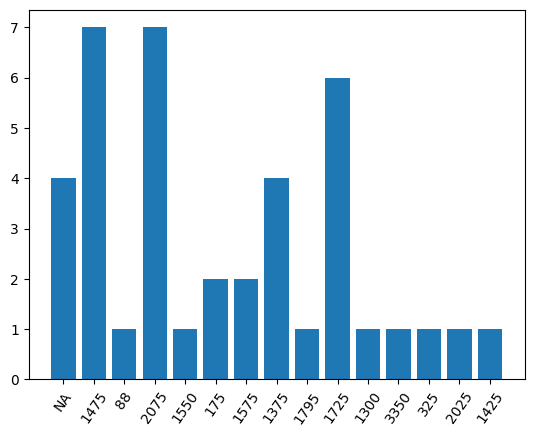

In [20]:
# 回答の出現頻度をヒストグラムとして表示します。
# matplotlib.pyplot をインポートします。
import matplotlib.pyplot as plt # グラフ描画ライブラリ

# グラフを作成します。
fig, ax = plt.subplots()  # Figure と Axes オブジェクトを作成

# ヒストグラムを作成します。
ax.bar(Counter(answers).keys(), Counter(answers).values())  # 回答とその出現回数でヒストグラムを作成

# x 軸のラベルを回転させます。
ax.tick_params(axis='x', rotation=55) # x 軸のラベルを 55 度回転

# グラフを表示します。
plt.show()

### 自己整合性の利点

1. 低エフォルトのパフォーマンスブースト。
1. 思考の模範を助けます。
1. 異なるLLMにわたる迅速な堅牢性の増加。
1. 回答分布に基づいて、擬似「信頼」推定値を提供します。
1. 単一の正解なしで問題に対して「平均」回答を使用する機会。

###自己整合性の欠点

1. コストの増加。
1. 推論時間の遅いおよび/またはスループットの削減。

### 自己整合のベストプラクティス

1. Do temperature=.7、top_k=40、top_p=1、そして10個のレスポンスを初期設定として使用しましょう。

  * ユースケースによって異なる値が必要になる場合があるため、そこから実験を行いましょう。
  * 本番環境で使用する最適な値を見つけるために、ハイパーパラメータ探索を実施しましょう。
  * LLMパラメータよりもレスポンス数を探索する方がはるかに価値がある可能性が高いことに注意してください。また、LLMパラメータを試す場合でも、それらを大幅に減らすことは通常価値がありません。

1. Do 初期のプロンプトエンジニアリングの試みが失敗した場合、早めに自己整合性を試しましょう。

  * 自己整合性は、連鎖思考プロンプトのエンジニアリングを続けるよりも、パフォーマンスを向上させる可能性が高いです。

1. Don't コストとレイテンシの影響を無視しないでください。

1. Do 実行時間を短縮するためにLLM呼び出しを並列化しましょう。

  * 自己整合性ユースケースに必要なLLMスループットとレイテンシの評価を後回しにしないでください。

1. Do レスポンス分布を創造的な方法で使用しましょう。例えば：

  * Xパーセント未満の回答しか一致しない場合、その質問にフラグを立てて人間のレビューに回しましょう。
  * 複数の要約を生成し、テキスト類似性指標を使用して、どの生成された要約が最も「平均的」かを特定しましょう。

1. Do 自己整合性をFew-Shot事例の作成やプロンプトのデバッグに活用しましょう。

# パート2：アクション、検索、ツールの使用

LLMは、カラスのように、ツールを使用するのに熟達しています。

<img src = "https://raw.githubusercontent.com/GoogleCloudPlatform/specialized-training-content/184be57c9ff4de18e20f3fdfbe1ef7fb35ce023f/courses/generative_ai/app_dev_llm/images/3-crow.png">

##幻覚、接地、ツール/アクション/検索/ぼろきれ
<a name="rag"> </a>

LLMは信頼できる事実源ではありません。LLM応答に正しい事実が含まれている場合、LLMのパラメーターが実際にエンコードするものの緊急効果です。単語間の確率的関係です。

事実の正確性が重要な場合、これらの確率的関係に依存することは危険です。

また、LLMSは、最新情報について迅速または安価に再訓練することもできません。また、再訓練が可能性がある場合でも、壊滅的な忘却は、トレーニングデータセットが増加するにつれて、古い情報の新しいエラーにつながる可能性があります。

LLM応答が事実上正しくない場合、それはしばしば「幻覚」と呼ばれますが、より正確には[妄想](https://en.wikipedia.org/wiki/delusion)です。

幻覚は非専門家によって見逃される可能性があります。LLM応答は、生成されたテキストが文法的に正確で、よく形成され、トーンに自信がある場合でも、事実上正しくありません。

このLLM呼び出しが出力するものを参照してください。

In [21]:
# LLM に対する質問を設定します。
question = "Who is Chancellor of Germany?"  # ドイツの首相は誰ですか？

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, question)

The call to the LLM:
Who is Chancellor of Germany?

The response:
Angela Merkel is the Chancellor of Germany.


現在のモデルは正しく反応する可能性がありますが、2023年8月、メルケル首相が辞任してからほぼ2年後、これが応答でした。
<img src = "https://raw.githubusercontent.com/GoogleCloudPlatform/specialized-training-content/184be57c9ff4de18e20f3fdfbe1ef7fb35ce023f/courses/generative_ai/app_dev_llm/images/6-hallucinate.png">

幻覚を管理する最良の方法は、LLMを正確で最新の外部データソースに接続することです。

「接地」とは、外部情報を使用して幻覚を管理することです。「グラウンド」する1つの方法は、挿入された情報に基づいて応答を基にするための手順とともに、外部情報をLLMコールに挿入することです。

「検索拡張生成」または「ラグ」は、LLMが外部知識を使用していると言う一般的な方法です。それは異なることを意味する可能性があります：
1. 外部検索システムは、ユーザークエリを入力として取得し、情報を出力し、LLMコールのユーザークエリと組み合わせます。（たとえば、クエリの埋め込みをドキュメントの埋め込みと比較し、LLMコールに最も近いドキュメントを挿入します）。[コードサンプル](https://github.com/googlecloudplatform/generative-ai/blob/main/language/use-cases/document-qa/question_answering_documents_langchain_matching_engine.ipynb)。

1. ユーザーのクエリに基づいて外部情報システムへの検索コールを策定する手順でLLMを呼び出し、ユーザーのクエリと取得情報を組み合わせてLLMに別の呼び出しを行います。

3. 結合したオーダーメイドレトリバーとジェネレーターディープラーニングモデルを一緒に訓練/調整しました（元の[RAG Paper](https://arxiv.org/pdf/2005.11401.pdf)の焦点）。

このノートブックは# 2に焦点を当てており、言語「ツール」/「ツール使用」を使用して、LLMを指示するように外部システムを使用するように説明し、あいまいな用語のぼろを避けます。パート3の後半では、「アクション」と「演技」を使用して、Reactが議論される方法と一致します。

## LLMツールの使用方法

LLMツールの使用の基本パターンは次のとおりです。
1. 以下を説明する最初のLLMコールを作成します。
* I：完了したいタスク。
* II：外部システム。
* III：外部システムへの呼び出しを策定する方法。
2. LLMによって生成された応答を使用して外部システムを呼び出します。
3.外部システムからの応答を含む2番目のLLMコールを作成し、LLMが外部システムからの応答を使用して元のタスクを完了するように指示します。

私たちのLLMシステムが、上記の首相の例のような事実ベースの質問に答えることになっている場合：
1. 最初のLLMコールは、LLMを指示して、知識ベースの検索クエリを生成します。
2. LLMの応答は、知識ベースを照会するために使用され、クエリの結果がキャプチャされます。
3. 2番目のLLMコールには、ナレッジベースクエリ、元の質問、およびLLMがナレッジベースクエリの結果を使用して質問に答えるための指示の結果が含まれます。

LLMのツールは、データベース、Web検索、ドキュメント検索システムなど、多くのものになる可能性があります。LLMシステムの一部は、LLMを外部情報ソースと統合するコードです。

このノートブックでは、ウィキペディアを外部情報ソースとして使用し、基本的なLLMシステムを構築して、事実ベースの質問に答えます。私たちのLLMシステムは次のとおりです。
1. LLMを呼び出して、ウィキペディア検索クエリを生成します。
1. ウィキペディアAPIを呼び出して、クエリの結果を取得します。
1. Wikipedia API応答と元の質問を使用して、LLMをもう一度呼び出します。

このノートブックの範囲を超えて、LLMSは、複数のツールを説明するInstandinosで呼び出すことができます。LLMはどちらもツールを選択し、ツールへの呼び出しを策定します。また、LLMツールは読み取り専用である必要はありません。ツールを使用して外部システムと対話できます（ただし、倫理と公平性への影響を考慮してください。Tは、 *幻覚は概要を尋ねたいと思っていますが、自動化された紙のグレーディングに影響を与えるように、誰かの人生に影響を与える可能性があるという決定を下すと、壊滅的です。誰かの人生）。

## サンプルツール

以下の関数はクエリを取り、クエリのトップウィキペディア記事マッチを返し、記事の最初の `return_chars`文字を取得します。

このツールは教育目的であり、やや制限されています。リストやサイドバーにアクセスすることはできず、提案をうまく処理せず、ウィキペディアの記事内での検索をサポートせず、常に結果を返すとは限りません。

In [22]:
# Wikipedia から情報を取得するツールを定義します。
# wikipedia ライブラリをインポートします。
import wikipedia

# Wikipedia から情報を取得する関数を定義します。
def wiki_tool(query, return_chars = 1000):
  try:
    # 検索クエリで Wikipedia ページを取得します (auto_suggest と redirect は False)。
    page = wikipedia.page(query, auto_suggest=False, redirect=True).content
  # If no exact match, take Wikipedia's auto-suggestion.
  except wikipedia.exceptions.PageError as e:
    # ページが見つからない場合は、auto_suggest を True にして再試行します。
    page = wikipedia.page(query, auto_suggest=True, redirect=True).content

  # ページの内容から指定された文字数までのスニペットを抽出します。
  snippet = page[0:return_chars]

  # スニペットとソース URL を返します。
  return snippet

ツールを試してください：

In [23]:
# wiki_tool 関数を使用して「ドイツの首相」に関する情報を取得します。
wiki_tool("chancellor of germany")

'The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander-in-chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).\nThe current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding Angela Merkel. He was elected after the SPD entered into a coalition agreement with Alliance 90/The Greens and the FDP.\n\n\n== History of the office ==\n\nThe office of Chancellor has a long history, stemming back to the Holy Roman Empire, when the office of German archchancellor was usually held by archbishops of Mainz. The title was, at times, used in several states of German-speaking Europe. The modern office of chancellor was established 

## チェーンLLMはツールの使用を求めています

基本的な2段階のツール使用LLMチェーンには、ここで段階的に分類されているいくつかのピースが含まれています。

この例でモデルを（2023年10月の時点で）、あいまいなミュージシャンについての質問に電話すると、誤った答えが幻覚を起こします。

In [24]:
# 質問を設定します。
question = "What musician released the album 'Somebody in the Snow'?"

# call_llm 関数を使用して LLM を呼び出し
_ = call_llm(model, parameters, question)

The call to the LLM:
What musician released the album 'Somebody in the Snow'?

The response:
The musician who released the album 'Somebody in the Snow' is the American singer-songwriter, actor, and record producer, John Mayer.


### ステップ1：ツールを使用するためのLLMの指示を提供する

LLMに、タスクとツールの使用方法の両方の指示を提供する必要があります。

LLM呼び出しのこの「命令」部分は、「コンテキスト」または「条件」（「コンディショニング」、「コンディショニングプロンプト」）のバリエーションと呼ばれることがあります。

In [25]:
# Wikipedia を参照して質問に答えるように指示を設定します。
context = """Answer questions using a lookup of Wikipedia.
After each question, write a Wikipedia search followed by '<STOP>'.
The Wikipedia search will be used to retrieve the most relevant content.
A section of the Wikipedia article will then be sent to the next LLM call.
Use the text of the Wikipedia article to answer the question."""

### ステップ2：模範を提供します

LLMには、ツールを使用してタスクを完了する方法を示す模範が必要です。

この例には、1ショットの模範的なものしかありません。

この模範のウィキペディアの記事のテキストは、2023年8月に「wiki_tool（ "chancellor ofドイツ"）を実行しています。

注：将来の再試行の後、LLMは外部ツールなしでこの質問に正しく答えます。しかし、このワンショットの模範は、ウィキペディア検索のパターン、応答、および応答に基づいた回答を示すため、まだ機能します。

In [26]:
# 模範を設定します。
exemplar = """Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding Angela Merkel. He was elected after the SPD entered into a coalition agreement with Alliance 90/The Greens and the FDP.\n\n\n== History of the office ==\nThe office of Chancellor has a long history, stemming back to the Holy Roman Empire, when the office of German archchancellor was usually held by archbishops of Mainz. The title was, at times, used in several states of German-speaking Europe. The modern office of chancellor was established with the
Answer: Olaf Scholz"""

### ステップ3：LLMチェーンで最初の呼び出しを行う

私たちのコンテキストと模範を質問と組み合わせて、Wikipediaの検索クエリを回答として要求するLLMに電話をかけます。

In [27]:
# 最初のステップの LLM への呼び出しを作成します。
step_one_call = f"""{context}

{exemplar}

Question: {question}
Wikipedia Search:"""

# call_llm 関数を使用して LLM を呼び出し、結果を step_one_response に格納します。
step_one_response = call_llm(model, parameters, step_one_call)

The call to the LLM:
Answer questions using a lookup of Wikipedia.
After each question, write a Wikipedia search followed by '<STOP>'.
The Wikipedia search will be used to retrieve the most relevant content.
A section of the Wikipedia article will then be sent to the next LLM call.
Use the text of the Wikipedia article to answer the question.

Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding

### ステップ4：LLMの応答を使用してツールをクエリします

注LLM応答には、Wikipedia検索クエリ以上のものが含まれています。

LLMSは、LLMコールのトークンと以前に予測されたトークンのトークンに基づいて、次のトークンを何度も繰り返し予測することで機能します。これは、LLMが過剰なテキストを生成することを意味します。ウィキペディア検索クエリの後に停止することはわかりません。

ウィキペディアの検索クエリを超えたすべてのものはごみです。余分なテキストは「<stop> `signifierを使用して破棄されますが、これはラインブレークでも実行できます。

生産システムでは、このようなLLMコールを行うときに応答サイズを制限することにより、コストを制御することが重要です。

次の関数は、最初のチェーンステップからLLM応答を取得し、ウィキペディアクエリを返します。

In [28]:
# LLM の応答から Wikipedia クエリを取得する関数を定義します。
def get_wiki_query (llm_response, stop_text = "<STOP>"):
  # クエリが最初の行にあると仮定します。
  first_line = llm_response.splitlines()[0] # 最初の行を取得

  # stop_text で分割し、最初の要素をクエリとして取得します。
  query = first_line.split(stop_text)[0]

  # 前後の空白を削除してクエリを返します。
  return query.strip() # Remove leading and trailing whitespace.

以前のLLMコールからの応答でこの関数を使用してクエリを抽出し、「wiki_tool」を使用してウィキペディアを検索します。

In [29]:
# get_wiki_query 関数を使用して Wikipedia クエリを取得します。
wiki_query = get_wiki_query(step_one_response)

# 取得したクエリを表示します。
print(f"Tool Query: {wiki_query}")

# wiki_tool 関数を使用して Wikipedia のスニペットを取得します。
wiki_text = wiki_tool(wiki_query)

# 取得したスニペットを表示します。
print(f"Wikipedia Snippet: {wiki_text}")

Tool Query: somebody in the snow
Wikipedia Snippet: Jandek is the musical project of Sterling Smith, a Houston, Texas-based American lo-fi folk singer. Since 1978, Jandek has independently released over 120 albums while granting an interview extremely rarely and providing no biographical information, releasing on a self-made label, "Corwood Industries". Jandek often plays an idiosyncratic and frequently atonal form of folk and blues music, frequently using an open and unconventional chord structure. AllMusic has described Jandek as "the most enigmatic figure in American music."


== History ==
A review of the debut album Ready for the House (1978)  in OP magazine, the first ever national press given to Jandek, referred to the artist as Sterling Smith. Smith has kept his personal history secret, revealing only one story about his pre-Corwood years: he wrote seven novels but burned them upon rejection from New York publishers.
In a 1985 private phone conversation with John Trubee for Spi

### ステップ5：ツール応答を使用して、LLMチェーンで2回目の呼び出しを行う

次に、ツールから出力を取得し、2番目のLLMコールを作成して質問に答えます。

LLMツールの使用は、一般に、以前の呼び出しと応答の履歴を維持しています。チェーン内の2番目の呼び出しを作成するには：
1. チェーン内の最初のLLMコールから始めます。
1. 以前に生成されたウィキペディアクエリを追加します。
1. ウィキペディアの検索結果を追加します。

これが私たちの最初の呼び出しがどのように見えるかを思い出させます：

In [30]:
# step_one_call 変数の内容を表示します。
# 最初のステップの LLM への呼び出しとして作成されたテキストです。
print(step_one_call)

Answer questions using a lookup of Wikipedia.
After each question, write a Wikipedia search followed by '<STOP>'.
The Wikipedia search will be used to retrieve the most relevant content.
A section of the Wikipedia article will then be sent to the next LLM call.
Use the text of the Wikipedia article to answer the question.

Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding Angela Merkel. He wa

この最初のLLMコールは、最初のLLM応答からのクエリと、ウィキペディアツールからの出力と、模範と一致する構造と組み合わされます。

In [31]:
# 2 番目のステップの LLM への呼び出しを作成します。
# 1 番目のステップの呼び出し、Wikipedia クエリ、Wikipedia 記事のスニペットを結合します。
step_two_call = f"""{step_one_call} {wiki_query}
Wikipedia Article: {wiki_text}
Answer: """

# call_llm 関数を使用して LLM を呼び出し、結果を step_two_response に格納します。
step_two_response = call_llm(model, parameters, step_two_call)

The call to the LLM:
Answer questions using a lookup of Wikipedia.
After each question, write a Wikipedia search followed by '<STOP>'.
The Wikipedia search will be used to retrieve the most relevant content.
A section of the Wikipedia article will then be sent to the next LLM call.
Use the text of the Wikipedia article to answer the question.

Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding

## すべてのステップをまとめる

下のこのコードスニペットは、上記のすべての手順、従属パッケージ、および従属関数を2段階のツール使用LLMチェーンを管理する単一の関数に収集します。

適切なパッケージをインストールして認証されたと仮定して、このコードを独自のプロジェクトにコピーして貼り付けることができます。

In [32]:
import wikipedia
# LLM を呼び出す関数を定義します。
def call_llm(model, parameters, llm_call, show_activity = True):
  # model.predict を使用して LLM を呼び出し、応答テキストを取得します。
  response = model.predict(llm_call, **parameters).text

  # show_activity が True の場合、呼び出しと応答を表示します。
  if show_activity:
    BOLD = "\033[1m"                                              # 太字にするためのエスケープシーケンス
    UNFORMAT = "\033[0m\x1B[0m"                                   # フォーマットをリセットするためのエスケープシーケンス
    print(f"{BOLD}The call to the LLM:{UNFORMAT}\n{llm_call}\n")  # 呼び出しを表示
    print(f"{BOLD}The response:{UNFORMAT}")                       # 応答を表示
    print(response)                                               # 応答テキストを表示

  return response  # 応答テキストを返します

# Wikipedia API を使用してクエリを検索し、指定された文字数までの結果を返す関数を定義します。
def wiki_tool(query, return_chars = 1000):
  try:
    # Wikipedia API を使用してクエリを検索します。
    # auto_suggest=False は、正確な一致のみを検索することを指定します。
    # redirect=True は、リダイレクトを許可することを指定します。
    page = wikipedia.page(query, auto_suggest=False, redirect=True).content
  # 正確な一致がない場合は、Wikipedia の提案を使用します。
  except wikipedia.exceptions.PageError as e:
    # Wikipedia API を使用してクエリを検索します。
    # auto_suggest=True は、提案を許可することを指定します。
    # redirect=True は、リダイレクトを許可することを指定します。
    page = wikipedia.page(query, auto_suggest=True, redirect=True).content
  # 指定された文字数までのコンテンツを返します。
  snippet = page[0:return_chars]
  return snippet

# LLM の応答から Wikipedia クエリを抽出する関数を定義します。
def get_wiki_query (llm_response, stop_text = "<STOP>"):
  # クエリが最初の行にあると仮定します。
  first_line = llm_response.splitlines()[0]

   # stop_text で分割し、最初の要素をクエリとして取得します。
  query = first_line.split(stop_text)[0]

  # 前後の空白を削除してクエリを返します。
  return query.strip()

# WikipediaツールとLLMを組み合わせて質問に答える関数を定義します。
def wiki_tool_chain(model,
                    parameters,
                    context,
                    exemplar,
                    question,
                    show_activity=False):

  # Wikipedia を使用して LLM を呼び出すことでクエリに答えます。
  # 最初のステップの LLM への呼び出しを作成します。
  step_one_call = (
      f"{context}\n\n{exemplar}\n\nQuestion: {question}\nWikipedia Search:"
  )

  # show_activity が True の場合、最初の呼び出しを表示します。
  if show_activity:
    print("\033[1mMaking the first LLM call...\033[0m\x1B[0m")

  # call_llm 関数を使用して LLM を呼び出し、結果を step_one_response に格納します。
  step_one_response = call_llm(model, parameters, step_one_call, show_activity)

  # get_wiki_query 関数を使用して Wikipedia クエリを取得します。
  wiki_query = get_wiki_query(step_one_response)

  # get_wiki_query 関数を使用して Wikipedia クエリを取得します。
  wiki_text = wiki_tool(wiki_query)

  # 2 番目のステップの LLM への呼び出しを作成します。
  step_two_call = (
      f"{step_one_call} {wiki_query}\nWikipedia Article: {wiki_text}\nAnswer: "
  )

  # show_activity が True の場合、2回目の呼び出しのメッセージを表示します。
  if show_activity:
    print("\033[1mMaking the second LLM call...\033[0m\x1B[0m")
  step_two_response = call_llm(model, parameters, step_two_call, show_activity)

  # 2 番目のステップの応答を返します。
  return step_two_response

上記のコードを使用する例：

In [33]:
# Vertex AI とテキスト生成モデルをインポートします。
import vertexai
from vertexai.language_models import TextGenerationModel

# このノートブックの外部で、PROJECT_ID、LOCATION、および MODEL_NAME を設定します。
# ノートブックで実行する場合、これらはパート 0 で設定されます。
vertexai.init(project=PROJECT_ID, location=LOCATION)

# これらの設定は、LLM 応答の決定性を制御します。
parameters = {
    "temperature": 0,           # 温度 - 値が低いほど応答が決定論的になります
    "max_output_tokens": 256,   # 生成される最大トークン数
    "top_p": 0.8,               # 上位p - 確率でサンプリングされるトークンの累積確率
    "top_k": 40                 # 上位k - サンプリングされる上位トークンの数
}

# TextGenerationModel をインスタンス化します。
model = TextGenerationModel.from_pretrained(MODEL_NAME)

# Wikipedia を参照して質問に答えるように LLM に指示するコンテキストを設定します。
context = """Answer questions using a lookup of wikipedia.
After each question, write a wikipedia search followed by '<STOP>'.
The wikipedia search will be used to retrieve the most relevant content.
A section of the wikipedia article will then be sent to the next LLM call.
Use the text of the wikipedia article to answer the question."""

# LLM に対する模範となる質問と回答の例を設定します。
exemplar = """Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected in December 2021, succeeding Angela Merkel. He was elected after the SPD entered into a coalition agreement with Alliance 90/The Greens and the FDP.\n\n\n== History of the office ==\nThe office of Chancellor has a long history, stemming back to the Holy Roman Empire, when the office of German archchancellor was usually held by archbishops of Mainz. The title was, at times, used in several states of German-speaking Europe. The modern office of chancellor was established with the
Answer: Olaf Scholz"""

# wiki_tool_chain 関数を使用して質問に答えます。
answer = wiki_tool_chain(model,
                         parameters,
                         context,
                         exemplar,
                         "What musician released the album 'Somebody in the Snow'?",  # 質問
                         show_activity = False)

# 回答を表示します。
print(answer)


Jandek


`show_activity = true`を使用して、LLMコールの内訳を確認します。

In [34]:
# wiki_tool_chain 関数を使用して質問に答え、処理の詳細を表示します。
wiki_tool_chain(model,
                parameters,
                context,
                exemplar,
                "What musician released the album 'Somebody in the Snow'?",  # 質問
                show_activity = True)

Making the first LLM call...
The call to the LLM:
Answer questions using a lookup of wikipedia.
After each question, write a wikipedia search followed by '<STOP>'.
The wikipedia search will be used to retrieve the most relevant content.
A section of the wikipedia article will then be sent to the next LLM call.
Use the text of the wikipedia article to answer the question.

Question: Who is Chancellor of Germany?
Wikipedia Search: chancellor of Germany<STOP>
Wikipedia Article: The chancellor of Germany, officially the federal chancellor of the Federal Republic of Germany, is the head of the federal government of Germany, and the commander in chief of the German Armed Forces during wartime. The chancellor is the chief executive of the Federal Cabinet and heads the executive branch. The chancellor is elected by the Bundestag on the proposal of the federal president and without debate (Article 63 of the German Constitution).The current officeholder is Olaf Scholz of the SPD, who was elected

'Jandek'

「質問」を変更して実験してみてください。`show_activity = true`を保持して、LLMチェーンの2つのステップを確認します。

これは多くの質問ではうまくいきません。上記のように、私たちのツールはあまり良くなく、いくつかの質問で完全に失敗します。

ツールの使用ベストプラクティスは[パート3で詳細](https://github.com/GoogleCloudPlatform/specialized-training-content/blob/184be57c9ff4de18e20f3fdfbe1ef7fb35ce023f/courses/generative_ai/app_dev_llm/#react-tools)。

# パート3：ReAct（推論 +行動）プロンプト

ReAct（推論 +行動）は、外部システムと対話することにより、複雑なタスクを介して、思考とツールの使用のチェーンとツールの使用を組み合わせて合計します。

ReActスタイルのプロンプトは、現在（2023年秋）ほとんどのプロンプト駆動型LLMタスクの最先端です。LLMまたはLLMベースのチャットボットまたはシステムが外部システムと対話するプラグインまたは拡張機能を使用すると、Reactスタイルのシステムを使用しています。一般に、最新の知識を反映するLLMシステムは、Hood-The-Hoodの下で反応スタイルの機能を使用して目に見えません。

外部システムと対話しようとするLLM：

<img src = "https://raw.githubusercontent.com/GoogleCloudPlatform/specialized-training-content/184be57c9ff4de18e20f3fdfbe1ef7fb35ce023f/courses/generative_ai/app_dev_llm/images/4-robot.png">

## 反応の基本

反応チェーンには通常、3つのインターリーブパーツがあります。
-  **思考**：思考の連鎖のように、これらは最終出力に向けて進歩するため、LLMによって生成されるウェイポイント、計画、推論などです。
-  **アクション**：LLMが生成したコマンド、呼び出し、または外部システムにアクセスする手順。外部システムは、情報を提供するツールである可能性がありますが、より一般的なものである可能性があります（つまり、アクションは外部システムの状態を観察または変更します）。
-  **観測**：外部システムからの応答、フィードバック、結果など。LLMコールに挿入されて次の思考を生成します。

これらの3つのステップは、LLMがタスクを完了するまで繰り返されます。

考え方のプロンプトと同様に、この繰り返されるサイクルは「内部の独白」または「内部スピーチ」を形成しますが、行動する決定を重要な追加と、単なる推論を超えて行動からフィードバックします。

### 反応チェーンはどのように見えますか

ReActチェーンでLLMコールを分解する前に、完全なReactチェーンがどのように見えるかを確認するのに役立ちます。

このチェーンでのアクションはウィキペディアの検索であり、観察はウィキペディアの記事からのスニペットです。

LLMへの元の呼び出しは次のとおりです。
「質問：誰が最初に生まれたのか、ロナルド・リーガンまたはジェラルド・フォード？」（今のところ、指示、模範などを無視して）。

完成したReactチェーンはこのように見えます。完全な観察結果を読むために右にスクロールします。

```
質問：最初に生まれたのは誰ですか、ロナルドレーガンまたはジェラルドフォード？
考え1：ロナルド・レーガンを調べて、彼がいつ生まれたのかを見る必要があります。
アクション1：ロナルドレーガン<Stop>
観察1：ロナルド・ウィルソン・レーガン（1911年2月6日 -  2004年6月5日）は、1981年から1989年まで米国の第40代大統領を務めたアメリカの政治家および俳優でした。そして、最初の離婚した大統領。レーガンはイリノイ州タンピコで生まれ、イリノイ州ディクソンで育ちました。彼はユーレカ大学で教育を受け、そこで経済学と社会学を学びました。卒業後、レーガンはカリフォルニアに移り、そこでラジオスポーツアナウンサーになりました。彼は後に演技に引っ越し、50以上の映画に出演しました。レーガンは、1947年から1952年までスクリーン俳優ギルドの社長を務めました。
考え2：ロナルド・レーガンは1911年に生まれました。ジェラルド・フォードを調べて、彼がいつ生まれたのかを見る必要があります。
アクション2：ジェラルドフォード<Stop>
観察2：ジェラルド・ルドルフ・フォード・ジュニア（jerr-əld;生まれたレスリー・リンチ・キング・ジュニア、1913年7月14日 -  2006年12月26日）は、1974年から1977年に米国第38代大統領を務めたアメリカの政治家でした。以前は、1965年から1973年まで米国下院で共和党の指導者を務め、スピロアグニューの辞任の後、リチャードニクソン大統領によって40番目の副大統領に任命されました。フォードは、ニクソンが1974年に辞任したときに大統領職に成功しましたが、1976年に完全な任期に選挙で敗北しました。フォードは、大統領または副大統領の選挙を勝ち取らずに米国大統領になった唯一の人物です。フォードはネブラスカ州オマハで生まれ、ミシガン州グランドラピッズで育ちました。彼はミシガン大学に通い、そこで学校のフットボールチームでプレーしてから最終的にイェールロースクールに通いました。その後、彼は1942年から1946年まで米国海軍保護区に勤務しました。フォードは1949年にミシガン州5の米国代表として政治的キャリアを始めました。
考え3：ジェラルドフォードは1913年に生まれました。1911年は1913年以前です。回答[ロナルドレーガン]
```

### 反応チェーンを分解します

上記の例の反応チェーンは、3つのLLM呼び出しから構築されています。

注このセクションの回答は、パート2ツールでのディスカッションで追加のテキストがどのように削除されたかと同様に、余分な予測されたテキストを削除されています。

**電話1：**
```
質問：最初に生まれたのは誰ですか、ロナルドレーガンまたはジェラルドフォード？
考え1：
```
**応答1：**
```
ロナルド・レーガンを調べて、彼がいつ生まれたのかを見る必要があります。
アクション1：ロナルドレーガン<Stop>
```

最初のLLMコールは次のとおりです。
1.以前のLLMコールプラス
1.前のコールプラスへのLLM応答
1.ウィキペディアルックアップ結果プラス
1.「思考#：」

**コール2：**

コール2は、連結コール1 +応答1 +ウィキペディアルックアップの結果（観察中） +「思考2：」によって作成されます。
```
質問：最初に生まれたのは誰ですか、ロナルドレーガンまたはジェラルドフォード？
考え1：ロナルド・レーガンを調べて、彼がいつ生まれたのかを見る必要があります。
アクション1：ロナルドレーガン<Stop>
観察1：ロナルド・ウィルソン・レーガン（1911年2月6日 -  2004年6月5日）は、1981年から1989年まで米国の第40代大統領を務めたアメリカの政治家および俳優でした。そして、最初の離婚した大統領。レーガンはイリノイ州タンピコで生まれ、イリノイ州ディクソンで育ちました。彼はユーレカ大学で教育を受け、そこで経済学と社会学を学びました。卒業後、レーガンはカリフォルニアに移り、そこでラジオスポーツアナウンサーになりました。彼は後に演技に引っ越し、50以上の映画に出演しました。レーガンは、1947年から1952年までスクリーン俳優ギルドの社長を務めました。
考え2：
```

**応答2：**
```
ロナルド・レーガンは1911年に生まれました。ジェラルド・フォードを調べて、彼がいつ生まれたのかを見る必要があります。
アクション2：ジェラルドフォード<Stop>
```

**電話3：**

コール2と同じように、Wikipedia Lookup + "Thought 3："の結果、コール2 +応答2 +を連結してコール3を作成します。

```
質問：最初に生まれたのは誰ですか、ロナルドレーガンまたはジェラルドフォード？
考え1：ロナルド・レーガンを調べて、彼がいつ生まれたのかを見る必要があります。
アクション1：ロナルドレーガン<Stop>
観察1：ロナルド・ウィルソン・レーガン（1911年2月6日 -  2004年6月5日）は、1981年から1989年まで米国の第40代大統領を務めたアメリカの政治家および俳優でした。そして、最初の離婚した大統領。レーガンはイリノイ州タンピコで生まれ、イリノイ州ディクソンで育ちました。彼はユーレカ大学で教育を受け、そこで経済学と社会学を学びました。卒業後、レーガンはカリフォルニアに移り、そこでラジオスポーツアナウンサーになりました。彼は後に演技に引っ越し、50以上の映画に出演しました。レーガンは、1947年から1952年までスクリーン俳優ギルドの社長を務めました。
考え2：ロナルド・レーガンは1911年に生まれました。ジェラルド・フォードを調べて、彼がいつ生まれたのかを見る必要があります。
アクション2：ジェラルドフォード<Stop>
観察2：ジェラルド・ルドルフ・フォード・ジュニア（jerr-əld;生まれたレスリー・リンチ・キング・ジュニア、1913年7月14日 -  2006年12月26日）は、1974年から1977年に米国第38代大統領を務めたアメリカの政治家でした。以前は、1965年から1973年まで米国下院で共和党の指導者を務め、スピロアグニューの辞任の後、リチャードニクソン大統領によって40番目の副大統領に任命されました。フォードは、ニクソンが1974年に辞任したときに大統領職に成功しましたが、1976年に完全な任期に選挙で敗北しました。フォードは、大統領または副大統領の選挙を勝ち取らずに米国大統領になった唯一の人物です。
フォードはネブラスカ州オマハで生まれ、ミシガン州グランドラピッズで育ちました。彼はミシガン大学に通い、そこで学校のサッカーチームでプレーしてから最終的にイェールロースクールに通いました。その後、彼は1942年から1946年まで米国海軍保護区に勤務しました。フォードは1949年にミシガン州5の米国代表として政治的キャリアを始めました。
考え3：
```

最後に、LLMは答えを返します。

**応答3：**
```
ジェラルドフォードは1913年に生まれました。1911年は1913年以前です。回答[ロナルドレーガン]
```

## ReActチェーンを手動で実行します

このセクションでは、ReActチェーンを段階的に実行します。

次のコードセルには、いくつかのことが必要です。
1. LLMが反応する方法を理解するための指示（コンテキスト）。
2.少なくとも1つの模範。
3. LLMのアクションを実行するツール。
4. LLM呼び出しを行うパームAPIモデルオブジェクト。

In [35]:
# LLMへの指示を設定します。思考、行動、観察を用いて質問に答えるように指示します。
context = """Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question."""

# LLMへの指示の例を設定します。ロナルド・レーガンとジェラルド・フォードのどちらが先に生まれたかという質問を例に、思考、行動、観察のプロセスを示します。
exemplar = """Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and see when he was born.
Action 1: Ronald Reagan<STOP>
Observation 1: Ronald Wilson Reagan (February 6, 1911 – June 5, 2004) was an American politician and actor who served as the 40th president of the United States from 1981 to 1989. A conservative, he was the first president from the West Coast and the first divorced president. Reagan was born in Tampico, Illinois, and raised in Dixon, Illinois. He was educated at Eureka College, where he studied economics and sociology. After graduating, Reagan moved to California, where he became a radio sports announcer. He later moved into acting, appearing in over 50 films. Reagan served as president of the Screen Actors Guild from 1947 to 1952.
Thought 2: Ronald Reagan was born in 1911. I need to look up Gerald Ford and see when he was born.
Action 2: Gerald Ford<STOP>
Observation 2: Gerald Rudolph Ford Jr. ( JERR-əld; born Leslie Lynch King Jr.; July 14, 1913 – December 26, 2006) was an American politician who served as the 38th president of the United States from 1974 to 1977. He previously served as the leader of the Republican Party in the U.S. House of Representatives from 1965 to 1973, when he was appointed the 40th vice president by President Richard Nixon, after Spiro Agnew's resignation. Ford succeeded to the presidency when Nixon resigned in 1974, but was defeated for election to a full term in 1976. Ford is the only person to become U.S. president without winning an election for president or vice president.
Ford was born in Omaha, Nebraska and raised in Grand Rapids, Michigan. He attended the University of Michigan, where he played for the school's football team before eventually attending Yale Law School. Afterward, he served in the U.S. Naval Reserve from 1942 to 1946. Ford began his political career in 1949 as the U.S. representative from Michigan's 5
Thought 3: Gerald Ford was born in 1913. 1911 is before 1913. Answer[Ronald Reagan]"""

# Wikipedia を呼び出すためのコードです。
import wikipedia  # wikipedia ライブラリをインポート

# Wikipedia API を使用してクエリを検索し、指定された文字数までの結果を返す関数を定義します。
def wiki_tool(query, return_chars = 1000):
  try:
    page = wikipedia.page(query, auto_suggest=False, redirect=True).content
  # 正確な一致がない場合は、Wikipedia の提案を使用します。
  except wikipedia.exceptions.PageError as e:
    page = wikipedia.page(query, auto_suggest=True, redirect=True).content
  # 指定された文字数までのコンテンツを返します。
  snippet = page[0:return_chars]
  return snippet

# PaLM API モデルを初期化します。
import vertexai
from vertexai.language_models import TextGenerationModel

vertexai.init(project=PROJECT_ID, location=LOCATION)

# これらの設定は、LLM 応答の決定性を制御します。
parameters = {
    "temperature": 0,
    "max_output_tokens": 256,
    "top_p": 0.8,
    "top_k": 40
}

# TextGenerationModel をインスタンス化します。
model = TextGenerationModel.from_pretrained(MODEL_NAME)


最初のLLMコールは、コンテキスト、模範、質問、および最初の思考のラベルです。

各ラインの開始時のアクション/思考/観測ラベルは、チェーンを反応するために重要であり、LLM応答がインターリーブ反応ステップの「スクリプト」に固執する可能性を高めます。

In [36]:
# 質問を設定します。
question = "When was the opening year of the theater that debuted Ibsen's 'A Doll's House'?"

# LLMへの最初の呼び出しを作成します。
llm_call_1 = f"{context}\n\n{exemplar}\n\nQuestion: {question}\nThought 1:"

# 最初の呼び出しを表示します。
print(llm_call_1)

Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and se

In [37]:
# LLM を呼び出し、最初の応答を取得します。
response_1 = call_llm(model, parameters, llm_call_1)

The call to the LLM:
Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up

応答の1行目と2行目は良いです。このモデルは、合理的な思考と適切なアクションを生成しました。

しかし、上記のツールを使用するのと同じように、LLMはごみのテキストを生成し続けます。LLMSは次のトークンを繰り返し予測し、ReactスタイルのLLMコールでは、次のトークンがRLMの残りのReactチェーンの予測であることを忘れないでください。

ツール使用セクションと同じように、追加のテキストが破棄されます。最初の2つの応答線のみが保持されます：「Thought 1」と「アクション1」。

In [38]:
# 応答の最初の2行のみを取得します。
# Splitlines は、各行のアイテムを含むリストを返します。
response_1 = response_1.splitlines()[0:2]

# response_1 をリストからテキストに変換して、llm_call_1 に連結できるようにします。
response_1 = ("\n").join(response_1)

# response_1 を表示します。
print(response_1)

I need to look up Ibsen's 'A Doll's House' and see where it debuted.
Action 1: A Doll's House<STOP>


次に、LLMの「アクション1」応答でウィキペディアツールをクエリします。

In [39]:
# LLM の行動を Wikipedia で検索します。
wiki_text_1 = wiki_tool("A Doll's House")   # "A Doll's House" を wiki_tool 関数で検索し、結果を wiki_text_1 に格納します
print(wiki_text_1)                          # wiki_text_1 を表示します

A Doll's House (Danish and Bokmål: Et dukkehjem; also translated as A Doll House) is a three-act play written by Norwegian playwright Henrik Ibsen. It premiered at the Royal Danish Theatre in Copenhagen, Denmark, on 21 December 1879, having been published earlier that month. The play is set in a Norwegian town c. 1879.
The play concerns the fate of a married woman, who, at the time in Norway, lacked reasonable opportunities for self-fulfillment in a male-dominated world. Despite the fact that Ibsen denied it was his intent to write a feminist play, it was a great sensation at the time and caused a "storm of outraged controversy" that went beyond the theater to the world of newspapers and society.
In 2006, the centennial of Ibsen's death, A Doll's House held the distinction of being the world's most-performed play that year. UNESCO has inscribed Ibsen's autographed manuscripts of A Doll's House on the Memory of the World Register in 2001, in recognition of their historical value.
The ti

次に、wikipediaツール出力を「観測1」として追加して、次のLLMコールを作成し、「観測2」の考えを追加します。

In [40]:
# 次の LLM 呼び出しを作成します。
llm_call_2 = f"{llm_call_1} {response_1}\nObservation 1: {wiki_text_1}\nThought 2:" #  previous_call, response, observation, thought を結合します
print(llm_call_2)                                                                   # llm_call_2 を表示します

Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and se

In [41]:
# LLM を呼び出し、2 番目の応答を取得します。
response_2 = call_llm(model, parameters, llm_call_2)

The call to the LLM:
Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up

Reactチェーンの3回目のLLMコールの場合、2回目の呼び出しと同じ手順に従います。
1. 応答の最初の2行を取ります。
2. ウィキペディアのアクションを調べます。
3. 応答、ウィキペディア出力、および以前のLLMコールからLLMコールを組み立てます。

In [42]:
# 応答の最初の2行のみを取得します。
# Splitlines は、各行のアイテムを含むリストを返します。
response_2 = response_2.splitlines()[0:2]

# response_2 をリストからテキストに変換して、llm_call_2 に連結できるようにします。
response_2 = ("\n").join(response_2)
print(response_2) # response_2 を表示します。

Ibsen's 'A Doll's House' premiered at the Royal Danish Theatre in Copenhagen, Denmark. I need to look up the opening year of the Royal Danish Theatre.
Action 2: Royal Danish Theatre<STOP>


In [43]:
# LLM の行動を Wikipedia で検索します。
wiki_text_2 = wiki_tool("Royal Theatre in Copenhagen, Denmark")
print(wiki_text_2)   # wiki_text_2 を表示します

The Royal Danish Theatre (RDT, Danish: Det Kongelige Teater) is both the national Danish performing arts institution and a name used to refer to its old purpose-built venue from 1874 located on Kongens Nytorv in Copenhagen. The theatre was founded in 1748, first serving as the theatre of the king, and then as the theatre of the country. The theatre presents opera, the Royal Danish Ballet, multi-genre concerts, and drama in several locations. The Royal Danish Theatre organization is under the control of the Danish Ministry of Culture.


== Performing arts venues ==
The Old Stage is the original Royal Danish Theatre built in 1874.
The Copenhagen Opera House (Operaen), built in 2004.
Stærekassen (New Stage) is an Art Deco theatre adjacent to the main theatre. It was used for drama productions. It is no longer used by the Royal Theatre.
The Royal Danish Playhouse is a venue for "spoken theatre" with three stages, inaugurated in 2008.


== Cultural references ==
The Royal Theatre on Kongens

In [44]:
# 次のLLMコールを構築します。
llm_call_3 = f"{llm_call_2} {response_2}\nObservation 2: {wiki_text_2}\nThought 3:"
print(llm_call_3)    # llm_call_3の内容を出力します。

Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and se

In [45]:
# call_llm関数を使用してLLMを呼び出し、結果を変数response_3に格納します。
response_3 = call_llm(model, parameters, llm_call_3)

The call to the LLM:
Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of Wikipedia.
The Wikipedia action returns the beginning of the best-matching article.
When making a Wikipedia lookup action, end the lookup with <STOP>.
After the Wikipedia action, you will have an observation.
The observation is based on what you learn from the Wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and having an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]" as part of a thought.
Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up

そして、私たちには答えがあります！

## Running Reactチェーンのための完全なPythonコードスニペット

アプリケーションでReactを使用するには、以前に手動で実行された手順を自動化する必要があります。

以下の指導的コードスニペットは、Reactチェーンを実行します。LLMへのフォーマットされたReactコールを作成し、アクションを抽出し、アクションを実行し、LLMが回答で応答したかどうかを検出します。

それは**非常に**あなたが以下のコードを歩いて、コメントを読んで、Reactチェーンがどのように自動化されているかをよりよく理解することをお勧めします。

これは生産対応のコードではありません：
1. スニペットは、この特定の最小限のReactの例にハードコードされています。Reactチェーンは異なるように見えます（これについては後で詳しく説明します）、Reactチェーンで構築された有用なアプリケーションにはカスタマイズされたツールが必要です。
2. スニペットは脆い、特にベアボーンウィキペディアツール。
3. LLMは、以前のアクションを再評価し、無限にループを反応させる可能性があります。このスニペットは、「MAX_STEPS」LLMコールの後に停止し、生産Reactコードはループをキャッチして回復しようとするはずです。

In [46]:
import wikipedia
# 指定されたモデルとパラメータを使用してLLMを呼び出す
def call_llm(model, parameters, llm_call, show_activity = True):
  # model.predictを使用してLLMを呼び出し、応答テキストを取得します。
  response = model.predict(llm_call, **parameters).text

  # show_activityがTrueの場合、呼び出しと応答を表示します。
  if show_activity:
    BOLD = "\033[1m"
    UNFORMAT = "\033[0m\x1B[0m"
    print(f"{BOLD}The call to the LLM:{UNFORMAT}\n{llm_call}\n")
    print(f"{BOLD}The response:{UNFORMAT}")
    print(response)
  return response  # Return to `_` if not needed.

# Wikipediaから情報を取得する
def wiki_tool(query, return_chars = 1000):
  try:
    page = wikipedia.page(query, auto_suggest=False, redirect=True).content
  # ページが見つからない場合の例外処理
  except wikipedia.exceptions.PageError as e:
    # 自動提案を有効化して再度ページの内容を取得します。
    page = wikipedia.page(query, auto_suggest=True, redirect=True).content
  snippet = page[0:return_chars]
  return snippet

# Wikipediaを使用してReActチェーンを実行
def wiki_react_chain(model,
                     parameters,
                     context,
                     exemplar,
                     question,
                     max_steps=7,
                     show_activity=False):
  # ReACTスタイルの思考→行動→観察ループでLLMを呼び出す。
  # LLMをmax_steps回呼び出すか、Answer[ans]のパターンで答えを呼び出す。
  # 最初のLLMコールを構築し、最初の思考をティーアップします。
  next_llm_call = f"{context}\n\n{exemplar}\n\nQuestion: {question}\nThought 1:"

  step = 1
  while step <= max_steps:

    if show_activity:
      print(f"\033[1mReAct chain step {step}:\033[0m\x1B[0m")
    llm_response = call_llm(model, parameters, next_llm_call, show_activity)

    # 回答を確認する。応答の最初の行のみを確認すること。
    # LLMは次の思考を超えて予測を続けるため。
    # これは脆弱であり、思考に改行がないことを前提としている。
    response_first_line = llm_response.splitlines()[0]
    first_line_answer_split = response_first_line.split("Answer[")
    if len(first_line_answer_split) > 1:  # もし 「Answer[」が分割された場合。
      # Answerの後に来る「]」を削除して # 答えを返す。
      return first_line_answer_split[1].split("]")[0]

    # 応答がない場合は、以下の応答ラインがアクションであると仮定する。
    response_second_line = llm_response.splitlines()[1]
    """
      Note the hard coded "<STOP>" characters marking the end of the action.
      This isn't strictly necessary if we assume the first line in the LLM
      response is the thought and the second is the action, and that any
      subsequent lines are garbage. But instructing the LLM to explicitly signal
      structure it the response often gives more structurally consistent
      responses, and also makes it easier to detect one way ReAct can fail.
    """
    # 応答の行動行からWikipediaクエリを抽出する。
    wiki_query = response_second_line.split(":")[1].split("<STOP>")[0]
    # 先頭/末尾の空白を削除する。
    wiki_query = wiki_query.strip()
    if show_activity:
      print(f"\033[1mQuerying wikipedia for: {wiki_query}.\033[0m\x1B[0m")
    wiki_text = wiki_tool(wiki_query)

    # 次のLLM呼び出しを組み立てる。
    # LLM応答の最初の思考と行動の行だけを使用する。
    usable_response = f"{response_first_line}\n{response_second_line}"
    # Wikipediaの応答を観察行に組み立てる。
    obs = f"Observation {step}: {wiki_text}"
    step += 1
    # 前回のLLM呼び出し + 応答の最初の行動と思考 +
    # Wikipedia検索の結果 = 次のReActステップのLLM呼び出し。
    # next_llm_callは前回行った呼び出しだが、ループが機能するように同じ変数名に再代入することに注意する。
    next_llm_call = f"{next_llm_call} {usable_response}\n{obs}\nThought {step}:"

  # 最大ステップ数を超えてループが終了した場合。
  # 例外を発生させる方が良いでしょう。
  return None

上記の反応チェーンコードスニペットを使用した例。

In [47]:
import vertexai
from vertexai.language_models import TextGenerationModel

# このノートブック以外では、PROJECT_ID、LOCATION、MODEL_NAMEを設定してください。
# ノートブック内で実行する場合は、パート0で設定されます。
vertexai.init(project=PROJECT_ID, location=LOCATION)

# これらの設定は、LLMの応答の決定性を制御します。
parameters = {
    "temperature": 0,
    "max_output_tokens": 256,
    "top_p": 0.8,
    "top_k": 40
}
model = TextGenerationModel.from_pretrained(MODEL_NAME)

context = """Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of wikipedia.
The wikipedia action returns the beginning of the best-matching article.
When making a wikipedia lookup action, end the lookup with <STOP>.
After the wikipedia action, you will make an observation.
The observation is based on what you learn from the wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and making an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]"
as part of a thought. Make sure to capitalize "Answer".

Only use information in the observations to answer the question."""

exemplar = """Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 1: I need to look up Ronald Reagan and see when he was born.
Action 1: Ronald Reagan<STOP>
Observation 1: Ronald Wilson Reagan (February 6, 1911 – June 5, 2004) was an American politician and actor who served as the 40th president of the United States from 1981 to 1989. A conservative, he was the first president from the West Coast and the first divorced president. Reagan was born in Tampico, Illinois, and raised in Dixon, Illinois. He was educated at Eureka College, where he studied economics and sociology. After graduating, Reagan moved to California, where he became a radio sports announcer. He later moved into acting, appearing in over 50 films. Reagan served as president of the Screen Actors Guild from 1947 to 1952.
Thought 2: Ronald Reagan was born in 1911. I need to look up Gerald Ford and see when he was born.
Action 2: Gerald Ford<STOP>
Observation 2: Gerald Rudolph Ford Jr. ( JERR-əld; born Leslie Lynch King Jr.; July 14, 1913 – December 26, 2006) was an American politician who served as the 38th president of the United States from 1974 to 1977. He previously served as the leader of the Republican Party in the U.S. House of Representatives from 1965 to 1973, when he was appointed the 40th vice president by President Richard Nixon, after Spiro Agnew's resignation. Ford succeeded to the presidency when Nixon resigned in 1974, but was defeated for election to a full term in 1976. Ford is the only person to become U.S. president without winning an election for president or vice president.
Ford was born in Omaha, Nebraska and raised in Grand Rapids, Michigan. He attended the University of Michigan, where he played for the school's football team before eventually attending Yale Law School. Afterward, he served in the U.S. Naval Reserve from 1942 to 1946. Ford began his political career in 1949 as the U.S. representative from Michigan's 5
Thought 3: Gerald Ford was born in 1913. 1911 is before 1913. Answer[Ronald Reagan]"""

question = "What city was the youngest of the three engineers who designed the Ford T Model born in?"

answer = wiki_react_chain(model,
                          parameters,
                          context,
                          exemplar,
                          question,
                          show_activity = True)
print(answer)


ReAct chain step 1:
The call to the LLM:
Answer questions with thoughts, actions, and observations.

Think about the next action to take. Then take an action.
All actions are a lookup of wikipedia.
The wikipedia action returns the beginning of the best-matching article.
When making a wikipedia lookup action, end the lookup with <STOP>.
After the wikipedia action, you will make an observation.
The observation is based on what you learn from the wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and making an observation.
Keep repeating as necessary until you know the answer to the question.
When you think you have an answer, return the answer in the format:
"Answer[answer goes here between square brackets]"
as part of a thought. Make sure to capitalize "Answer".

Only use information in the observations to answer the question.

Example:
Question: Who was born first, Ronald Reagan or Gerald Ford?
Thought 

上記の「質問」を変更して実験します。あなたは素晴らしい結果を得ることができないかもしれません。これは、脆いウィキペディアツールによるものかもしれませんが、反応のエラーも表示される場合があります。

コンテキストまたは模範を変更することにより、反応障害のパフォーマンスをどのように改善できるかを考えてください。

## その他の反応のユースケース

ReActパターンは、質問に答えるだけではありません。

異なるコンテキストと模範で、上記のReactコードスニペットは事実チェックに適合しています。

In [48]:
question = "The GDP of Japan is higher than the GDP of BRICS."

context = """You are verifying claims as true or false.
Verify the claim with thoughts, actions, and observations.
Determine if there is an observation that SUPPORTS or REFUTES the claim.

Think about the next action to take to verify the claim. Then take an action.
All actions are a lookup of wikipedia.
The wikipedia action returns the beginning of the best-matching article.
When making a wikipedia lookup action, end the lookup with <STOP>.
After the wikipedia action, you will make an observation.
The observation is based on what you learn from the wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and making an observation.
Keep repeating as necessary until you reach a conclusion about the claim.
If an observation refutes the claim, return the answer as "Answer[REFUTES]".
If an observation supports the claim, return the answer as "Answer[SUPPORTS]".

Only use information in the observations to answer the question."""

exemplar = """Example:
Claim: Ronald Reagan was born before Gerald Ford.
Thought 1: I need to look up Ronald Reagan and see when he was born.
Action 1: Ronald Reagan<STOP>
Observation 1: Ronald Wilson Reagan (February 6, 1911 – June 5, 2004) was an American politician and actor who served as the 40th president of the United States from 1981 to 1989. A conservative, he was the first president from the West Coast and the first divorced president. Reagan was born in Tampico, Illinois, and raised in Dixon, Illinois. He was educated at Eureka College, where he studied economics and sociology. After graduating, Reagan moved to California, where he became a radio sports announcer. He later moved into acting, appearing in over 50 films. Reagan served as president of the Screen Actors Guild from 1947 to 1952.
Thought 2: Ronald Reagan was born in 1911. I need to look up Gerald Ford and see when he was born.
Action 2: Gerald Ford<STOP>
Observation 2: Gerald Rudolph Ford Jr. ( JERR-əld; born Leslie Lynch King Jr.; July 14, 1913 – December 26, 2006) was an American politician who served as the 38th president of the United States from 1974 to 1977. He previously served as the leader of the Republican Party in the U.S. House of Representatives from 1965 to 1973, when he was appointed the 40th vice president by President Richard Nixon, after Spiro Agnew's resignation. Ford succeeded to the presidency when Nixon resigned in 1974, but was defeated for election to a full term in 1976. Ford is the only person to become U.S. president without winning an election for president or vice president.
Ford was born in Omaha, Nebraska and raised in Grand Rapids, Michigan. He attended the University of Michigan, where he played for the school's football team before eventually attending Yale Law School. Afterward, he served in the U.S. Naval Reserve from 1942 to 1946. Ford began his political career in 1949 as the U.S. representative from Michigan's 5
Thought 3: Gerald Ford was born in 1913. Ronald Reagan was born in 1911. 1911 is before 1913. Ronald Reagan was born before Gerald Ford. Answer[SUPPORTS]"""

answer = wiki_react_chain(model,
                          parameters,
                          context,
                          exemplar,
                          question,
                          show_activity = True)
print(answer)


ReAct chain step 1:
The call to the LLM:
You are verifying claims as true or false.
Verify the claim with thoughts, actions, and observations.
Determine if there is an observation that SUPPORTS or REFUTES the claim.

Think about the next action to take to verify the claim. Then take an action.
All actions are a lookup of wikipedia.
The wikipedia action returns the beginning of the best-matching article.
When making a wikipedia lookup action, end the lookup with <STOP>.
After the wikipedia action, you will make an observation.
The observation is based on what you learn from the wikipedia lookup action.
After the observation, begin the loop again with a thought.

Repeat as necessary a thought, taking an action, and making an observation.
Keep repeating as necessary until you reach a conclusion about the claim.
If an observation refutes the claim, return the answer as "Answer[REFUTES]".
If an observation supports the claim, return the answer as "Answer[SUPPORTS]".

Only use information in

ウィキペディアツールの制限は、このプロンプトのユーティリティを制限し、ニュートラルな「十分な情報」の回答に対するサポートの欠如も同様です。

ただし、このユースケースにどのように簡単に適応したかを考えてください。反応パターンは、次のことでも良い結果を示しています。
* テキストベースの仮想世界とのナビゲートと対話。
* Webをサーフィンします。
* 購入手順を使用して、eコマーストランザクションを作成します。
* ジャーナル記事の文献検索の実施。

<a name="react-tools"> </a>
## ツールの使用ベストプラクティス

上記のプロンプトを実験した場合、おそらく失敗が発生した可能性があります。多くの場合、これはウィキペディアツールが限られているためです。

いくつかのベストプラクティスに従うことで、この教育の例よりも堅牢で効果的なツールを構築するのに役立ちます。

1. Do プロンプト内でツールとその使用方法を明確に記述しましょう。
  * 理想的なツール使用を示すfew-shot事例を含めましょう。
  * 例えば、「doc search」とだけ記述されたツールは、「自然言語クエリを使用して社内文書を検索します。レスポンスは、クエリとの関連性が高い順に並べられた文書名のリストです。」のように記述された同じツールよりもパフォーマンスが低くなります。
2. Do ツールの範囲と複雑さを慎重に検討しましょう。
  * ツールのAPIがLLMにとって十分にシンプルかどうかを検討しましょう。
  * 多くの場合、1つの複雑なツールよりも複数のシンプルなツールの方が効果的です。開発者にとっては単一のAPIであっても、LLMツールとしては複数のツールに分けた方が良い場合があります。
  * 例えば、ユースケースでデータベースにアクセスするためにSQLを実行する必要がある場合、LLMを使用してSQLクエリを最初から生成するのではなく、いくつかの個別のSQLテンプレートを個々のツールとして検討しましょう。
3. Do ツール出力を構造的および文体的に一貫させましょう。
  * ツール出力のバリエーションが少ないほど、LLMがその出力を効果的に使用する可能性が高くなります。
4. Do ツール出力を短く、関連性の高いものにしましょう。
  * 冗長なツール出力は、LLMの入力長制限に負担をかける可能性があります。
  * ReAct論文のWikipediaエージェント実装は素晴らしい例です。Wikipedia記事内を検索し、記事全体ではなく、見つかった用語の周辺のテキストスニペットのみを返します。
5. Do エラーを適切に処理しましょう。
  * 例外をキャッチし、有用なエラーメッセージを提供しましょう。
  * タイムアウトやレート制限などのツール側の問題を管理しましょう。
  * few-shot事例でエラー処理を示しましょう。
  * ツールが失敗し、次のLLM呼び出しで有用なエラーを提供した場合、LLMは自己修正する可能性があります。
6. Do ツール使用プロンプトをチューニングしましょう。
  * 様々なツール使用を含むパラメータ効率の良いチューニングセット（わずか10個の例でも）は、パフォーマンスを大幅に向上させることができます。
7. Do LLMを呼び出してツールアクションを生成する際の出力長を制限しましょう。
  * LLMはツールアクションを超えてテキストを生成し続けます。
8. Don't セキュリティを忘れないでください。多くのツール使用パターンはセキュリティリスクを生み出します。
  * LLMのツールを介してアクセス可能なものはすべて、敵対的な入力で実験するエンドユーザーに見られる可能性があると想定しましょう。
  * LLMのツール呼び出しが悪意のあるものであることはないと想定しないでください。例えば、SQLインジェクションはLLMツールを介して可能です。

このノートブックのツールは、これらのベストプラクティスの多くに従っていません。

1. Wikipediaの記事は構造が予測できません。
1. Wikipediaの記事は数千語になることもありますが、このツールは記事の関連部分に焦点を当てることをサポートしていません。
1. プロンプトではWikipediaとは何か、またはその使用方法が説明されていません（ただし、LLMはトレーニングデータからWikipediaが何かを「知って」います）。
1. エラーメッセージがなく、エラー処理は最小限です。


## 利点を反応します

1. 幻覚が少ない。
  * 信頼できる情報源とLLMの「メモリ」に依存する接地。
1. 再訓練なしでLLMの知識を更新/拡張します。
1. 既製のLLMSで動作し、追加のLLMトレーニングやチューニングは必要ありません。
1. さまざまなユースケースをサポートします。
1. 複数のツールで動作します。
1. ツールを改善することでシステム全体のパフォーマンスを改善することは、プロンプトまたはLLM自体を改善するよりも簡単です。

## React Disdvantages

1. 複数のLLM呼び出しにより、遅い（高レイテンシー）および高価です。
1. 外部ツールは、維持およびセキュリティの懸念を維持し、より多くのシステムコンポーネントを意味します。
1. 反応ループとその他の非回答シナリオが一般的です。
  * Vs.幻覚がより一般的であると思考の連鎖。
  * 専門的または最新の情報を必要としないユースケースの場合、思考の連鎖は反応する可能性があります。
1. 反応推論（Think-> Act）は柔軟性が低く、純粋な一連の思考の連鎖のより柔軟な推論とパフォーマンスが低下する可能性があります。
1. 外部情報が必要な場合、RAGよりも複雑な場合、検索がLLMによって制御されない場合にアプローチします。
1. ツール統合を超えて、追加の機能が必要です。
  * ループ救済。
  * ツールエラーの管理。
  * 思考のチェーンフォールバック。

## ベストプラクティスを反応します

[ツール使用](https://github.com/GoogleCloudPlatform/specialized-training-content/blob/184be57c9ff4de18e20f3fdfbe1ef7fb35ce023f/courses/generative_ai/app_dev_llm/#react-tools)上記のベストプラクティスを超えて。

1. Don't temperature=0を盲目的に使用しないでください。
  * タスクやツールの記述方法によってパフォーマンスが大きく変わる可能性があります。
  * "Thought"、"Action"、"Observation"以外のラベルとステップのスキップを含む事例を試してみましょう。
  * 様々な思考/推論と行動スタイルの事例を試してみましょう。例えば：
    * 次のアクションを特定する思考が最適なタスクもあれば、最初の思考で完全な計画を立てるのが最適なタスクもあります。
    * 無関係な観察やツールエラーの後に計画を調整したり、前の思考を再考したりする思考/行動を示しましょう。
  * 直前の観察の最も重要な部分を言い換える思考を試してみましょう。
1. Do ReActチェーンがループに陥るのをキャッチしましょう。
  * ループのキャッチを示す事例で実験しましょう。
  * 繰り返される行動をキャッチし、繰り返される行動を指摘する観察をLLMに返すことを検討しましょう。LLMは回復できるかもしれません。
  * temperature > 0でループしているチェーンを再実行してみましょう。
  * ReActが研究ベンチマークデータセットで最先端である場合、それは多くの場合、連鎖思考の自己整合性フォールバックを伴います。
1. Do ファインチューニングを活用しましょう。
  * ReActチェーン全体にわたるチューニング事例を含め、最初または最後のLLM呼び出しの事例だけでなく、全体を含めましょう。
  * エラー/失敗処理をチューニングデータに含めましょう。
  * 最終的な答えが正しい場合でも、不正確なReAct推論を含むチューニング事例を使用しないでください。
1. Don't より単純な代替案を評価せずにReActを実装しないでください。
  * 管理された拡張機能/プラグインを検討しましょう。
    * 拡張機能サービスは、セキュリティ、可観測性、監視、評価などを提供し、実装作業を削減する可能性があります。
    * 技術的な評価なしに、管理された拡張機能/プラグインサービスがニーズを満たすと想定しないでください。
  * 外部知識をLLM呼び出しに統合するより簡単な方法を検討しましょう。（例：上記のRAGパターン1）。
1. Do 大規模なReActのデバッグにLLMを使用しましょう。
  * LLMに、タイプ別に失敗を分類する（例：推論ミス、ツール検索失敗、ループに陥った）および/またはReActチェーンの各ステップを正しいか間違っているかを識別するように促します。
1. Do テスト、パフォーマンス測定（ドリフトを含む）、システム監視、CI/CDなどにツール機能を含めましょう。

# パート4：LangchainとReAct
<img src = "https://raw.githubusercontent.com/GoogleCloudPlatform/specialized-training-content/184be57c9ff4de18e20f3fdfbe1ef7fb35ce023f/courses/generative_ai/app_dev_llm/images/5-chained.png">

Langchain は、LLM をすぐに始めるための優れたライブラリです。多くの[ツールの統合](https://python.langchain.com/docs/integrations/tools/)や組み込みの [ReAct エージェント](https://python.langchain.com/docs/modules/agents/agent_types/react)など、さまざまな便利な機能が備わっています。

ただし、Langchainとの反応は、すべてのユースケースに最適ではない場合があります。Langchainを使用して使用する場合は、ニーズを満たしているかどうかを評価することが重要です。

Langchainが現在ユースケースのニーズを満たしていないことがわかった場合でも、Langchainが1.0リリースに近づくと機能が追加されることに注意してください。

Langchainには、[Langsmith](https://docs.smith.langchain.com/)という名前で利用可能な独自の評価と生産ツールもあります。

## 基本的なLangchain React Agent

LangchainでのReActの主な利点は、開始するのが非常に少ない作業であることです。

In [49]:
from langchain.agents import AgentType, initialize_agent, load_tools
from langchain.llms import VertexAI
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
import wikipedia
import vertexai

# これはVertex AIへのLangChain接続です。
# これはvertexai.init（パート0で実行）に依存することに注意してください。
llm = VertexAI(model_name=MODEL_NAME, temperature=0)

# Wikipediaツールを初期化する。
_ = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
# この次の行は前の行に不可視的にマッピングされます。
#   Langchainがその「wikipedia」を使用するためには、WikipediaQueryRun呼び出しがここで重要であり、
#   その呼び出しが出力される変数ではありません。
tools = load_tools(["wikipedia"], llm=llm)

# ReActエージェントを作成する。
agent = initialize_agent(tools,
                         llm,
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION)

# エージェントの動作を確認するために、この質問を変更することができます。
# wikipedia APIからGuessedAtParserWarningが表示される場合がありますが、無視してください。
agent.run("What US President costarred with a chimp in 'Bedtime for Bonzo'?")

/root/.local/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /root/.local/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


'Ronald Reagan'

Langchain のもう 1 つの優れた機能は、組み込みの[ツール統合](https://python.langchain.com/docs/integrations/tools/)です。特に便利なツールの 1 つは数学用です。LLM は数学が苦手ですが、外部計算機があれば数学のパフォーマンスが向上します。

In [50]:
# 答えは4489です。
# タイムアウトやエラーが発生する可能性がありますが、問題ありません。
agent.run("What's 67^2?")

'Agent stopped due to iteration limit or time limit.'

In [51]:
# llm-mathツールをエージェントが利用できるようにする。
tools = load_tools(["wikipedia", "llm-math"], llm=llm)
agent = initialize_agent(tools,
                         llm,
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION)
agent.run("What's 67^2?")

'4489'

## 観測可能性の課題

デフォルトでは、LangchainはReactチェーンの最終出力のみを返します。しかし、特にデバッグするときは、すべてのLLMコールを見ることが必要な場合があります。

Langchainには、基礎となるLLMコールにある程度の観測性を提供する冗長モードが含まれています。

In [52]:
# verboseはrunではなく、エージェント宣言の一部であることに注意してください。
agent = initialize_agent(tools,
                         llm,
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
                         verbose=True)

agent.run("What US President costarred with a chimp in 'Bedtime for Bonzo'?")



> Entering new AgentExecutor chain...
I need to find out what US President costarred with a chimp in 'Bedtime for Bonzo'
Action: Wikipedia
Action Input: bedtime for bonzo

/root/.local/lib/python3.10/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /root/.local/lib/python3.10/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')



Observation: Page: Bedtime for Bonzo
Summary: Bedtime for Bonzo is a 1951 American comedy film directed by Fred de Cordova and starring Ronald Reagan, Diana Lynn, and a chimpanzee named Peggy as Bonzo. Its central character, a psychology professor (Reagan), tries to teach human morals to a chimpanzee, hoping to solve the "nature versus nurture" question.
A sequel, Bonzo Goes to College, was released in 1952, but featured none of the three lead performers from the original film.



Page: Bedtime for Democracy
Summary: Bedtime for Democracy is the fourth and final studio album by American punk rock band Dead Kennedys. Released in 1986, songs on this album cover common punk subjects often found in punk rock lyrics of the era such as conformity, Reaganomics, the U.S. military, and critique of the hardcore punk movement. The album's title refers to the 1951 comedy film, Bedtime for Bonzo starring Ronald Reagan and also reflects the band's weary bitterness from the trial they were undergoin

'Ronald Reagan'

ここで、冗長モードは、最初の考えでは、LLMがその内部知識を使用したことを示しています。

しかし、エージェントがどのように回答に到達したか、またはエージェントが失敗した理由を理解するのに冗長モードは常に十分ではありません。

In [53]:
# ReActエージェントを実行し、質問「2010年9月1日は何曜日でしたか？」に答えます。
agent.run("What day of the week was September 1st, 2010?")



> Entering new AgentExecutor chain...
I need to know what day of the week September 1st, 2010 was
Action: Calculator
Action Input: 1 September 2010

ValueError: LLMMathChain._evaluate("
datetime.datetime(2010, 9, 1)
") raised error: Expression datetime.datetime(2010, 9, 1) has forbidden control characters.. Please try again with a valid numerical expression

完全にデバッグするには、Langchain 内部の可視性を向上させる必要があります。 このカスタム可観測性コードのスニペット (この[ノートブック](https://github.com/GoogleCloudPlatform/specialized-training-content/blob/184be57c9ff4de18e20f3fdfbe1ef7fb35ce023f/courses/generative_ai/langchain_observability_snippet/langchain-observability-snippet.ipynb)からのもの) は、Langchain の[コールバック ハンドラー](https://python.langchain.com/docs/modules/callbacks/)を使用して、エージェントの実行時に何が起こるかを正確に示します。

In [ ]:
# @title
# Import dependencies.
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import AgentAction, AgentFinish, Document, LLMResult
import pdb
from prettyprinter import cpprint
from typing import Any, Dict, List, Optional, Sequence, Type, Union
from uuid import UUID

# Two helper classes.
class Color():
  """For easier understanding and faster manipulation of printed colors."""
  PURPLE = "\033[95m"
  CYAN = "\033[96m"
  DARKCYAN = "\033[36m"
  BLUE = "\033[94m"
  GREEN = "\033[92m"
  YELLOW = "\033[93m"
  RED = "\033[91m"
  BOLD = "\033[1m"
  UNDERLINE = "\033[4m"
  ITALICS = "\x1B[3m"
  END = "\033[0m\x1B[0m"



class OutputFormatter:
  """ Helper class to control the format of printed output from the callbacks.

  If used in prod, consider reimplementing in a way that removes hardcoding
    of where the output is written. Maybe use Python logging and then pass a
    custom configuration?
  """
  # コールバックから出力される印刷形式を制御するためのヘルパークラス。
  # 本番環境で使用する場合は、出力先をハードコーディングしない方法で再実装することを検討してください。
  # Pythonのロギングを使用し、カスタム設定を渡すのも良いかもしれません。
  # TODO: Add str casting here to reduce f"{}" in callback class to this class.
  def heading(text: str) -> None:
    print(f"{Color.BOLD}{text}{Color.END}")

  def key_info(text: str) -> None:
    print(f"{Color.BOLD}{Color.DARKCYAN}{text}{Color.END}")

  def key_info_labeled(label: str,
                       contents: str,
                       contents_newlined: Optional[bool] = False
                       ) -> None:
    print(f"{Color.BOLD}{Color.DARKCYAN}{label}: {Color.END}{Color.DARKCYAN}",
          end="")
    if contents_newlined:
      contents = contents.splitlines()
    cpprint(f"{contents}")
    print(f"{Color.END}", end="")

  def debug_info(text: str) -> None:
    print(f"{Color.BLUE}{text}{Color.END}")

  def debug_info_labeled(label: str,
                         contents: str,
                         contents_newlined: Optional[bool] = False
                         ) -> None:
    print(f"{Color.BOLD}{Color.BLUE}{label}: {Color.END}{Color.BLUE}",
          end="")
    if contents_newlined:
      contents = contents.splitlines()
    cpprint(f"{contents}")
    print(f"{Color.END}", end="")

  def llm_call(text: str) -> None:
    print(f"{Color.ITALICS}{text}{Color.END}")

  def llm_output(text: str) -> None:
    print(f"{Color.UNDERLINE}{text}{Color.END}")

  def tool_call(text: str) -> None:
    print(f"{Color.ITALICS}{Color.PURPLE}{text}{Color.END}")

  def tool_output(text: str) -> None:
    print(f"{Color.UNDERLINE}{Color.PURPLE}{text}{Color.END}")

  def debug_error(text: str) -> None:
    print(f"{Color.BOLD}{Color.RED}{text}{Color.END}")

# 実際のLangChainコールバックハンドラーで、これはLangChainの実行中にステータス更新を生成します。
class AllChainDetails(BaseCallbackHandler):
  """Outputs details of chain progress and state.

  Exposes details available at callback time to each executed step in a chain.

  Method arguments in this class are based on the (most of?) the arguments
    available to the callback method, though not all implementations in this
    class use all the arguments.

  Usage:
    Pass as an argument to a langchain method or class that accepts a callback
      handler. Note that  not all langchain classes will invoke all callbacks
      when the callback handler is provided at initialization time, so the
      recommended usage is to provide the callback handler when executing a
      chain.

  Example:
    from langchain import LLMChain, PromptTemplate
    from langchain.llms import VertexAI
    import vertexai  # Comes from google-cloud-aiplatform package.
    vertexai.init(project=PROJECT_ID, location=REGION)

    llm = VertexAI(temperature=0)  # Use any LLM.
    prompt_template = "What food pairs well with {food}?"
    handler = AllChainDetails()
    llm_chain = LLMChain(
      llm=llm,
      prompt=PromptTemplate.from_template(prompt_template))
    llm_chain("chocolate", callbacks=[handler])

  Args:
    debug_mode: If True, prints more details of each chain step and activates
      breakpoints (using pdb) when unexpected behavior is detected. Note that
      the breakpoints are in the callbacks, which limits the amount of
      inspectable langchain state to what langchain surfaces to callbacks.
    out: Class for managing output, only tested with the OutputFormatter
      accompanying this class.
  """

  def __init__(self,
               debug_mode: Optional[bool] = False,
               out: Type[OutputFormatter] = OutputFormatter,
               ) -> None:
    self.debug_mode = debug_mode
    self.out = out

  def on_llm_start(self,
                   serialized: Dict[str, Any],
                   prompts: List[str],
                   **kwargs: Any) -> None:
    """Run when langchain calls an LLM."""
    self.out.heading(f"\n\n> Sending text to the LLM.")

    if len(prompts) > 1:
      self.out.debug_error("prompts has multiple items.")
      self.out.debug_error("Only outputting first item in prompts.")
      if self.debug_mode:
        self.out.debug_info_labeled("Prompts", f"{prompts}")
        pdb.set_trace()

    self.out.key_info(f"Text sent to LLM:")
    self.out.llm_call(prompts[0])

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("serialized", f"{serialized}")

  def on_llm_end(self, response: LLMResult, **kwargs: Any) -> None:
    """Run after LLM response is received by langchain."""
    self.out.heading(f"\n\n> Received response from LLM.")

    if len(response.generations) > 1:
      self.out.debug_error("response object has multiple generations.")
      self.out.debug_error("Only outputting first generation in response.")
      if self.debug_mode:
        self.out.debug_info_labeled("response", f"{response}")
        pdb.set_trace()

    self.out.key_info(f"Text received from LLM:")
    self.out.llm_output(response.generations[0][0].text)

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("response", f"{response}")

  def on_tool_start(self,
                    serialized: Dict[str, Any],
                    input_str: str,
                    **kwargs: Any,) -> None:
    """Run when making a call to a tool."""
    self.out.heading(f"\n\n> Using tool.")
    self.out.key_info_labeled(f"Tool name", f"{serialized['name']}")
    self.out.key_info(f"Query sent to tool:")
    self.out.tool_call(input_str)

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("serialized", f"{serialized}")

  def on_tool_end(
      self,
      output: str,
      color: Optional[str] = None,
      observation_prefix: Optional[str] = None,
      llm_prefix: Optional[str] = None,
      **kwargs: Any,) -> None:
    """Run on response from a tool."""
    self.out.heading(f"\n\n> Received tool output.")
    self.out.key_info_labeled(f"Tool name", f"{kwargs['name']}")

    if "output" not in locals():
      self.out.debug_error("No tool output.")
      if self.debug_mode:
        pdb.set_trace()
    else:
      self.out.key_info("Response from tool:")
      self.out.tool_output(f"{output}")

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("observation_prefix",
                                  f"{observation_prefix}")
      self.out.debug_info_labeled("llm_prefix",
                                  f"{llm_prefix}")

  def on_agent_action(self,
                      action: AgentAction,
                      color: Optional[str] = None,
                      **kwargs: Any) -> Any:
    """Run when agent performs an action."""
    self.out.heading(f"\n\n> Agent taking an action.")

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("action", f"{action}")

  def on_agent_finish(self,
                      finish: AgentFinish,
                      color: Optional[str] = None,
                      **kwargs: Any) -> None:
    """Run after agent completes."""
    self.out.heading(f"\n\n> Agent has finished.")

    if self.debug_mode:
      self.out.debug_info_labeled("Arguments", f"{kwargs}")
      self.out.debug_info_labeled("finish",
                                  f"{finish}")

  def on_llm_error(self,
                   error: Union[Exception, KeyboardInterrupt],
                   **kwargs: Any) -> None:
    self.out.debug_error("LLM Error")
    self.out.debug_info_labeled("Error object", f"{error}")
    if self.debug_mode:
      pdb.set_trace()

  def on_chain_error(self,
                     error: Union[Exception, KeyboardInterrupt],
                     **kwargs: Any) -> None:
    self.out.debug_error("Chain Error")
    self.out.debug_info_labeled("Error object", f"{error}")
    if self.debug_mode:
      pdb.set_trace()

  def on_tool_error(self,
                    error: Union[Exception, KeyboardInterrupt],
                    **kwargs: Any) -> None:
    self.out.debug_error("Chain Error")
    self.out.debug_info_labeled("Error object", f"{error}")
    if self.debug_mode:
      pdb.set_trace()

カスタム観測可能性コードを含むエージェントを使用して、失敗したクエリを繰り返します。

In [ ]:
# AllChainDetailsコールバックハンドラを初期化します。
handler = AllChainDetails()

# ReActエージェントを初期化します。
agent = initialize_agent(tools,
                         llm,
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION)

# ReActエージェントを実行し、質問「2010年9月1日は何曜日でしたか？」に答えます。
# 実行中のすべての詳細をコールバックハンドラに出力します。
agent.run("What day of the week was September 1st, 2010?",
          callbacks=[handler])

LLMに送信された正確な呼び出しが表示され、LLMがツール（「ツールを使用する」）を選択したとき、LLMのツールへの入力（「ツールに送信されたクエリ：」）、および次のLLMアクティビティが表示されます。

エラーの性質は明確になりました。数学ツールは、LLMに「numexpr」ライブラリで実行する式を作成するように指示しますが、LLMには誤って式に「DateTime」ライブラリが含まれています。

さらに、LLMは、Langchainを呼び出して、ツールの説明や正確なReact実装（標準の思考 - >アクション - >観測とは異なる）を含む反応を実行するために使用します。

### Langchainでの生産観測可能性

安定した生産LLMシステムを実行するには、おそらく集中型の外部ロギング/監視プラットフォームで、強力な観察可能性とロギングが必要です。これがなければ、システムが正しく実行されていることを確認することはできず、デバッグできない場合があります。

Langchainのコールバックの実装はここで役立ち、一部のMLプラットフォームベンダーはLangchainコールバックハンドラーを提供しています。

ただし、一部のユースケースでは、カスタムラングチェーンコールバックハンドラーを作成する必要があります。また、システムに依存しているラングチェーンモジュールの他の部分に応じて、必要な情報をコールバックに表現するためにLangchain内部を変更する必要があります。

## ツールのカスタマイズ摩擦

Langchainエージェントに「DateTime」サポートを追加する方法は次のとおりです。

1. 数学ツールがReactプロンプトで説明されている方法を変更するため、LLMは「DateTime」を使用しないことを知っています。
1. DateTime Operations専用の新しいツールを作成し、LLMが利用できるようにします。
1. Langchain Mathツールを変更して、「DateTime」サポートを追加します。
1. langchain数学ツールを変更して、「numexpr」から例外をキャッチし、次のコールでLLMにエラーメッセージを提供して、LLMが別のアクションを実行できるようにします。

これらには、Langchain内部の知識や、まだ文書化されていないLangchain機能を使用する必要があります。

さらに、最良の反応性能のために、指示、模範、およびツールの説明を調整する必要があります。これは、「DateTime」ツールの問題を管理する以外に、[カスタムLangchainエージェント](https://python.langchain.com/docs/modules/agents/)を作成する必要があることを意味します。

多くのユースケースでは、この摩擦は克服する価値があります。しかし、フレームワークを採用するという決定と同様に、ソフトウェア開発のベストプラクティスに従い、利用可能なフレームワークと構築の長所と短所をゼロから完全に調査します。